Reproducible conda environment used: file tf_cpu-linux-64.lock 

In [1]:
import sys
from pathlib import Path
import os
sys.path.insert(0,str(Path(os.path.abspath('')).parent))
from proj_config import *
import scipy as sp
import pandas as pd
import numpy as np
import scipy
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas_utils
import timeit
import hot_encoding as oh
from importlib import reload

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import keras_tuner as kt
import keras_utils
from keras_utils import metrics as kumet
from sklearn import metrics as skmet
from skmet_wrappers import *
import json
import gc

models_dir = get_modelsdir() / "mimic-omop/sequentialNN_3/"
datadir = get_datadir() / "mimic-omop/pre-processed/"
plots_dir = get_project_root()/"docs/latex/overleaf/gfx/"
tables_dir = get_project_root()/"docs/latex/overleaf/tables/"

# Change matplotlib default style for publication style figures with correct
# fontsize for a twocolumn LaTeX layout
fig_width_pt = 252.0  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inches
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height =fig_width*golden_mean       # height in inches
fig_size = [fig_width,fig_height]
single_col_fig_size = fig_size
dual_col_fig_size = tuple(np.asarray(single_col_fig_size)*2)

params = {'backend': 'pdf',
          'axes.labelsize': 8.0,
          'axes.labelpad': 3.0,
          #'text.fontsize': 10,
          'legend.fontsize': 7.0,
          'legend.labelspacing': 0.2,
          'legend.handletextpad': 0.4,
          'xtick.labelsize': 7.0,
          'ytick.labelsize': 7.0,
          'text.usetex': False,
          'figure.figsize': fig_size,
          'savefig.bbox': "tight"}
plt.rcParams.update(params)

2023-09-08 17:36:24.049074: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-08 17:36:24.050864: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 


# Analyze results
## MIMIC stats

In [146]:
oh_diagnoses_df = pd.read_parquet(datadir/"oh_diagnoses_rollup.parquet")

In [147]:
icd9_concepts = pd.read_csv(datadir / "icd9_concepts.csv.gz")
icd9_allcodes = icd9_concepts.concept_code
icd9_chapters = icd9_concepts.query('concept_class_id=="Chapter"').concept_code
icd9_subchapters = (icd9_concepts.query('concept_class_id=="SubChapter"').concept_code)
icd9_3dig = (icd9_concepts.query('concept_class_id.str.startswith("3-dig",na=False)').concept_code)
icd9_4dig = (icd9_concepts.query('concept_class_id.str.startswith("4-dig",na=False)').concept_code)
icd9_5dig = (icd9_concepts.query('concept_class_id.str.startswith("5-dig",na=False)').concept_code)
icd9_billing = (icd9_concepts.query('concept_class_id.str.endswith("-dig billing code",na=False)').concept_code)

### Table 2: ICD Codes per stay in MIMIC-III 

In [148]:
# Build number of codes per stay table
n_codes_df = pd.DataFrame()
for code_set,name in zip([icd9_chapters,icd9_subchapters,icd9_3dig,icd9_4dig,icd9_5dig,icd9_billing,icd9_allcodes],
                            ['Chapters','Subchapters','3 digits','4 digits','5 digits','Billing','All levels']):
    tmp = oh_diagnoses_df.loc[:,oh_diagnoses_df.columns[oh_diagnoses_df.columns.isin(code_set)]].sum(axis=1).squeeze()
    tmp_df = pd.DataFrame({'Min':tmp.min(),'Max':tmp.max(),'Median':tmp.median(),'Mean':tmp.mean(),'SD':tmp.std()},index=[name])
    n_codes_df = pd.concat([n_codes_df,tmp_df],axis=0)
n_codes_df.Median = n_codes_df.Median.astype(int)
n_codes_df.style.format(precision=2).to_latex(buf=tables_dir/"codes_per_stay_AllMIMIC.tex",
                environment='void',hrules=True,clines="skip-last;index",column_format='lrrrrr')

### Table S2: ICD codes per stay in the cherry-picked subset

In [149]:
# Build the same table for cherry picked codes (Sagi style)
from project_miscellaneous import filter_Sagi_diagnoses
sagi_codes = filter_Sagi_diagnoses(oh_diagnoses_df=oh_diagnoses_df)
oh_diagnoses_sagi_df = oh_diagnoses_df.loc[:, ~oh_diagnoses_df.columns.isin(sagi_codes)]
n_codes_df = pd.DataFrame()
for code_set,name in zip([icd9_chapters,icd9_subchapters,icd9_3dig,icd9_4dig,icd9_5dig,icd9_billing,icd9_allcodes],
                            ['Chapters','Subchapters','3 digits','4 digits','5 digits','Billing','All levels']):
    code_set = code_set[code_set.isin(oh_diagnoses_sagi_df.columns)]
    tmp = oh_diagnoses_sagi_df.loc[:,code_set].sum(axis=1).squeeze()
    tmp_df = pd.DataFrame({'Min':tmp.min(),'Max':tmp.max(),'Median':tmp.median(),'Mean':tmp.mean(),'SD':tmp.std()},index=[name])
    n_codes_df = pd.concat([n_codes_df,tmp_df],axis=0)
n_codes_df.Median = n_codes_df.Median.astype(int)
n_codes_df.style.format(precision=2).to_latex(buf=tables_dir/"codes_per_stay_Sagi.tex",
                environment='void',hrules=True,clines="skip-last;index",column_format='lrrrrr')

### Table 1: Unique codes per ICD9 level

In [150]:
# Build the table containing the number of unique codes
n_codes_df = pd.DataFrame()
for code_set,name in zip([icd9_chapters,icd9_subchapters,icd9_3dig,icd9_4dig,icd9_5dig,icd9_billing,icd9_allcodes],
                            ['Chapters','Subchapters','3 digits','4 digits','5 digits','Billing','All levels']):
    tmp_df = pd.DataFrame({'ICD9-CM':len(code_set),
                            'MIMIC III':sum(oh_diagnoses_df.columns.isin(code_set)),
                            'Cherry picked':sum(oh_diagnoses_sagi_df.columns.isin(code_set))},index=[name])
    n_codes_df = pd.concat([n_codes_df,tmp_df],axis=0)
n_codes_df.style.format(precision=2).to_latex(buf=tables_dir/"unique_codes_perlevel.tex",
                environment='void',hrules=True,clines="skip-last;index",column_format='lrrr')

### Fig. S1 Zipf plot

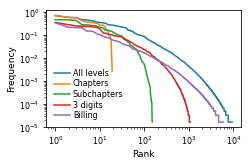

In [154]:
# Make a Zipf rank/frequency plot
for code_subset,code_subset_name in zip([icd9_allcodes, icd9_chapters, icd9_subchapters, icd9_3dig, icd9_billing],
                                       ['All levels', 'Chapters', 'Subchapters', '3 digits', 'Billing']
                                       ):
    code_subset = code_subset[code_subset.isin(oh_diagnoses_df.columns)]
    freqs = (oh_diagnoses_df.loc[:,code_subset].sum(axis=0)/oh_diagnoses_df.shape[0]).sort_values(ascending=False)
    plt.plot(range(1,len(freqs)+1),freqs, label=code_subset_name)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Rank')
plt.ylabel("Frequency")
plt.legend(frameon=False)
plt.savefig(plots_dir/"zipf_plot.pdf")

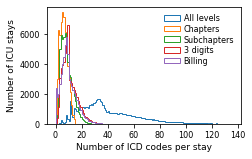

In [155]:
# Plot number of codes per stay distribution
for code_subset,code_subset_name in zip([icd9_allcodes, icd9_chapters, icd9_subchapters, icd9_3dig, icd9_billing],
                                       ['All levels', 'Chapters', 'Subchapters', '3 digits', 'Billing']):
    code_subset = code_subset[code_subset.isin(oh_diagnoses_df.columns)]
    n_codes = oh_diagnoses_df.loc[:,code_subset].sum(axis=1)
    plt.hist(n_codes,bins=range(0,max(n_codes)), label=code_subset_name, histtype='step')
plt.xlabel('Number of ICD codes per stay')
plt.ylabel("Number of ICU stays")
plt.legend(frameon=False)
plt.savefig(plots_dir/"codes_per_stay_distribution.pdf")

In [11]:
icd_concepts_subset = icd9_concepts.concept_class_id
value_counts = icd_concepts_subset.value_counts()
for pattern, code_level_name in zip(['Chapter','SubChapter','3-dig','billing'],
                                   ['Chapter','Subchapter','3 digits','Billing']):
    

array([ True,  True, False,  True, False,  True,  True, False, False,
       False,  True, False,  True, False,  True])

In [12]:
icd9_concepts.concept_class_id.value_counts()

5-dig billing code      8212
4-dig billing code      3863
4-dig nonbill code      1730
4-dig billing E code    1247
3-dig nonbill code       836
5-dig billing V code     634
4-dig billing V code     474
3-dig nonbill E code     172
4-dig nonbill V code     159
SubChapter               154
3-dig billing code        92
3-dig nonbill V code      89
3-dig billing E code      44
Chapter                   19
3-dig billing V code       1
Name: concept_class_id, dtype: int64

## Performance metrics

In [32]:
def listdir_only(path):
    """List directories in a directory"""
    f_list = os.listdir(path)
    d_list = []
    for i in f_list:
        if os.path.isdir(path/i):
            d_list.append(i)
    return d_list

In [33]:
def read_best_model_json_file(path, filename, n):
    with open(path/"best_models"/str(n)/filename, "r") as json_file:
        res = json.load(json_file)
    return res

def get_best_models_perfs(path, n, dataset="test"):
    """Read evaluate json file for the Nth best model."""
    filename = "evaluate_"+dataset+".json"
    return read_best_model_json_file(path,filename,n)


def get_best_model_hyperparms(path, n):
    return read_best_model_json_file(path,"model_hyperparameters.json",n)

def process_model_str(df,sep=' '):
    df = df.copy()
    df['input_data'] = ''
    for pattern,datastr in zip(['drugSexAge',"drug"],
                            ["Drugs, Sex, Age",'Drugs']):
        df.loc[df.model_str.str.startswith(pattern),'input_data'] = datastr
        df.model_str = df.model_str.str.removeprefix(pattern).str.strip(sep)
    df['code_subset'] = ''
    
    # Check if the last characters are numeric and process the index
    model_suffix = df.model_str.str.rpartition(sep='_')
    isnum = model_suffix.loc[:,2].str.isnumeric()
    df.loc[isnum,'model_str'] = model_suffix.loc[isnum,0]
    # set index to 0 for models without index
    model_suffix.loc[~isnum,2] = '0'
    # check if there is a second numeric character (my weird naming convention is 
    # inputvars_methodname_codesubset_crossvalid_modelid)
    model_sec_suffix = df.model_str.str.rpartition(sep='_')
    issecnum = model_sec_suffix.loc[:,2].str.isnumeric()
    df.loc[issecnum,'model_str'] = model_sec_suffix.loc[issecnum,0]
    model_sec_suffix.loc[~issecnum,2] = '0'

    # folders named blabla_crossvalid_modelid
    df.loc[issecnum,'model_id'] = model_suffix.loc[issecnum,2].astype('int')
    df.loc[issecnum,'crossval_id'] = model_sec_suffix.loc[issecnum,2].astype('int')
    # folders named blabla_crossvalid or just blabla
    df.loc[~issecnum,'crossval_id'] = model_suffix.loc[~issecnum,2].astype('int')
    df.loc[~issecnum,'model_id'] = model_sec_suffix.loc[~issecnum,2].astype('int')
    
    for pattern,code_subset in zip(['Sagi',"AllCodes"],
                        ["Sagi",'All codes']):
        df.loc[df.model_str.str.endswith(pattern),'code_subset'] = code_subset
        df.model_str = df.model_str.str.removesuffix(pattern).str.strip(sep)
        
    df.loc[df.model_str=="",'model_str'] = "Vanilla"
    df.dropna(axis=0, subset="metric_value", inplace=True)
    df.rename(columns={'model_str':'model'},inplace=True)
    df.loc[df.model.isin(['Chapters','Subchapters','3dig','billing']),'model'] = "Per level"
    return df

def cleanup_per_level_entries(df):
    df = df.copy()
    code_levels = ['All', 'Chapter', 'Subchapter', '3 digits', 'Billing']
    for pattern, code_level in zip(['Chapters','Subchapters','3dig','billing'],
                                  code_levels[1:]):
        exclude_code_set = set(code_levels) - set([code_level])
        df = df.loc[~(df.code_level.isin(exclude_code_set) & df.model_str.str.contains(pattern)), :]
    return df

In [5]:
# Small test of the above model_str parser
parser_test_df = process_model_str(pd.DataFrame({'model_str':['drugSexAge_HierL2_AllCodes_2',
                                                            'drugSexAge_HierL2_AllCodes',
                                                            'drugSexAge_HierL2_AllCodes_0_2'],
                                'metric_value':0.0
}))
try:
    assert (parser_test_df.model == "_HierL2_").all()
    assert (parser_test_df.model_id == np.array([0,0,2])).all()
    assert (parser_test_df.crossval_id == np.array([2,0,0])).all()
except:
    print(parser_test_df)
    raise AssertionError

print(parser_test_df)
del parser_test_df


      model  metric_value       input_data code_subset  model_id  crossval_id
0  _HierL2_           0.0  Drugs, Sex, Age   All codes       0.0          2.0
1  _HierL2_           0.0  Drugs, Sex, Age   All codes       0.0          0.0
2  _HierL2_           0.0  Drugs, Sex, Age   All codes       2.0          0.0


In [4]:
import warnings
warnings.filterwarnings('ignore', 'No positive class found in y_true, recall is set to one for all thresholds.', )
warnings.filterwarnings('ignore', 'No positive samples in y_true, true positive value should be meaningless')
def per_sample_auc_PR(y_true,probas_pred,pos_label=None):
    prec = {}
    rec = {}
    thresh = {}
    auc = {}
    y_true = np.asarray(y_true)
    probas_pred = np.asarray(probas_pred)
    for row in range(0,probas_pred.shape[0]):
        prec[row],rec[row],thresh[row] = skmet.precision_recall_curve(y_true=y_true[row,:],
                                                                      probas_pred=probas_pred[row,:],
                                                                      pos_label=pos_label)
        auc[row] = skmet.auc(rec[row],prec[row])
    return np.array(list(auc.values()))

def per_sample_f1(y_true, y_pred, *args, **kwargs):
    sample_f1 = skmet.f1_score(y_true=y_true.transpose(),
                          y_pred=y_pred.transpose(),
                          average=None,
                          *args,**kwargs)
    return sample_f1

def per_sample_average_precision(y_true, y_score, *args, **kwargs):
    sample_AP = skmet.average_precision_score(y_true=y_true.transpose(),
                          y_score=y_score.transpose(),
                          average=None,
                          *args,**kwargs)
    return sample_AP

def per_sample_AUROC(y_true, y_score, **kwargs):
    # Filter out samples without any code
    #sample_auroc = skmet.roc_auc_score(y_true=y_true.transpose(),
    #                  y_score=y_score.transpose(),
    #                  average=None,
    #                  *args,**kwargs)
    #return sample_auroc
    fpr = {}
    tpr = {}
    thresh = {}
    auc = {}
    y_true = np.asarray(y_true)
    probas_pred = np.asarray(y_score)
    for row in range(0,probas_pred.shape[0]):
        fpr[row],tpr[row],thresh[row] = skmet.roc_curve(y_true=y_true[row,:],
                                                        y_score=probas_pred[row,:],
                                                        **kwargs)
        auc[row] = skmet.auc(fpr[row],tpr[row])
    return np.array(list(auc.values()))

def per_sample_metric(metric_fn,y_true,y_score,*args,**kwargs):
    y_true = np.asarray(y_true)
    y_score = np.asarray(y_score)
    sample_metric = np.zeros(y_score.shape[0])
    for row in range(0,y_score.shape[0]):
        sample_metric[row] = metric_fn(y_true[row:row+1,:],y_score[row:row+1,:],*args,**kwargs)
    return sample_metric

def per_sample_LRAP(y_true,y_score,*args,**kwargs):
    return per_sample_metric(skmet.label_ranking_average_precision_score,y_true,y_score,*args,**kwargs)

def per_sample_NDCG(y_true,y_score,*args,**kwargs):
    return per_sample_metric(skmet.ndcg_score,y_true,y_score,*args,**kwargs)

def sample_averaged_auc_PR(y_true,probas_pred,pos_label=None):
    return per_sample_auc_PR(y_true,probas_pred,pos_label).mean()

def sample_averaged_AUROC(y_true,probas_pred,pos_label=None):
    return per_sample_AUROC(y_true,probas_pred,pos_label=pos_label).mean()

def micro_averaged_auc_PR(y_true,probas_pred,pos_label=None):
    y_true = np.asarray(y_true)
    probas_pred = np.asarray(probas_pred)
    prec,rec,thresh = skmet.precision_recall_curve(y_true=y_true.ravel(),
                                                   probas_pred=probas_pred.ravel(),
                                                   pos_label=pos_label)
    return skmet.auc(rec,prec)

def macro_averaged_auc_PR(y_true,probas_pred,pos_label=None):
    prec = {}
    rec = {}
    thresh = {}
    auc = {}
    y_true = np.asarray(y_true)
    probas_pred = np.asarray(probas_pred)
    for col in range(0,probas_pred.shape[1]):
        prec[col],rec[col],thresh[col] = skmet.precision_recall_curve(y_true=y_true[:,col],
                                                                      probas_pred=probas_pred[:,col],
                                                                      pos_label=pos_label)
        auc[col] = skmet.auc(rec[col],prec[col])
    return np.array(list(auc.values())).mean()

def per_code_AUROC(y_true,probas_pred,pos_label=None):
    fpr = {}
    tpr = {}
    thresh = {}
    auc = {}
    y_true = np.asarray(y_true)
    probas_pred = np.asarray(probas_pred)
    for col in range(0,probas_pred.shape[1]):
        fpr[col],tpr[col],thresh[col] = skmet.roc_curve(y_true=y_true[:,col],
                                                         y_score=probas_pred[:,col],
                                                         pos_label=pos_label)
        auc[col] = skmet.auc(fpr[col],tpr[col])
    return np.array(list(auc.values()))

def macro_averaged_AUROC(y_true,probas_pred,pos_label=None):
    return per_code_AUROC(y_true,probas_pred,pos_label=pos_label).mean()

def filter_no_positive_sample(y_true,y_score):
    y_true = np.asarray(y_true)
    y_score = np.asarray(y_score)
    not_all_neg = y_true.any(axis=1)
    return y_true[not_all_neg, :],y_score[not_all_neg, :]

def filter_no_positive_label(y_true,y_score):
    y_true = np.asarray(y_true)
    y_score = np.asarray(y_score)
    not_all_neg = y_true.any(axis=0)
    return y_true[:, not_all_neg],y_score[:, not_all_neg]

def one_error(y_true, y_score, pos_label=1):
    y_true = np.asarray(y_true)
    y_score = np.asarray(y_score)
    top_pred = np.full_like(y_score,fill_value=np.nan)
    top_pred[np.arange(len(y_score)), y_score.argmax(1)] = 1
    one_error = (y_true==top_pred).sum(axis=1)
    return one_error

def average_relevance_position(y_true, y_score, pos_label=1):
    y_true = np.asarray(y_true)
    y_score = np.asarray(y_score)
    ranks = (-y_score).argsort(axis=1).argsort(axis=1).astype(float)
    #print(y_score[1,ranks.astype(int)[1,0:15]])
    ranks[y_true!=pos_label]=np.nan
    #print(ranks[0,:][~np.isnan(ranks[0,:])])
    return np.nanmean(ranks+1.0,axis=1)

def sample_averaged_ARP(y_true, y_score,*args,**kwargs):
    return average_relevance_position(y_true, y_score, *args, **kwargs).nanmean()

def precision_recall_at_K(y_true, y_score, k, pos_label=1, rectified_precision = True):
    y_score = np.asarray(y_score)
    y_true = np.asarray(y_true)==pos_label
    arg_sorted_scores = (-y_score).argsort(axis=1)
    sorted_truth = np.take_along_axis(y_true, arg_sorted_scores,axis=1)
    summed_truth = np.cumsum(sorted_truth, axis=1, dtype=np.float64)
    n_codes = np.sum(y_true,axis=1).reshape([-1,1])
    n_codes = np.where(n_codes==0,np.nan,n_codes)
    recall = np.divide(summed_truth,n_codes)
    n_codes_seen = np.arange(1,y_true.shape[1]+1,1,dtype=np.float32).reshape([1,-1])
    if rectified_precision:
        def get_last_non_zero_per_row(x):
            return np.where(np.count_nonzero(x, axis=1)==0, np.nan, (x.shape[1]-1) - np.argmin(x[:,::-1]==0, axis=1))
        last_relevant_rank = get_last_non_zero_per_row(sorted_truth).reshape([-1,1])+1
        precision = summed_truth/np.where(last_relevant_rank<=n_codes_seen,last_relevant_rank,n_codes_seen)
    else:
        precision = summed_truth/n_codes_seen
    if k is None:
        return (precision,recall)
    else:
        return (precision[:,k],recall[:,k])

In [7]:
# Convert csv.gz files to feather format with half (float16) precision for faster reading (30x faster than csv.gz), half storage space.
raise RuntimeError # This is a long computation uncomment this error to proceed
models_dir = get_modelsdir() / "mimic-omop/sequentialNN_3/"
met_dirs = listdir_only(models_dir)
for metric in met_dirs:
    exp_dirs = listdir_only(models_dir/metric)
    for exp in exp_dirs:
        exp_models_dir = models_dir/metric/exp/"best_models"
        for n in range(1,2):
            best_model_dir = exp_models_dir/str(n)
            if not os.path.exists(best_model_dir/"predictions_test.feather"):
                try:
                    tmp = pd.read_csv(best_model_dir/"predictions_test.csv.gz")
                    tmp = tmp.astype({'visit_occurrence_id':'int64'})
                    dtype_dict = dict([(col,'float16') for col in tmp.select_dtypes(include='float64').columns])
                    tmp = tmp.astype(dtype_dict)
                    # Parquet Takes 2x more space than the csv.gz equivalent file with full precision and does not support half precision
                    #tmp.to_parquet(best_model_dir/"predictions_test.parquet",index=False,compression='brotli') 
                    tmp.to_feather(best_model_dir/"predictions_test.feather")
                    del tmp
                except:
                    continue

In [4]:
# ReCompute evaluation metrics using sklearn using test prediction files
test_visits = pd.read_csv(datadir/'test_visits_id.csv.gz').squeeze()
train_visits = pd.read_csv(datadir/'train_visits_id.csv.gz').squeeze()
oh_diagnoses_df = pd.read_parquet(datadir/"oh_diagnoses_rollup.parquet").set_index('visit_occurrence_id')
test_oh_diagnoses_df = oh_diagnoses_df.loc[test_visits,:]
train_oh_diagnoses_df = oh_diagnoses_df.loc[train_visits,:]
test_oh_diagnoses_df.sort_index(ascending=True,inplace=True)
icd9_concepts = pd.read_csv(datadir / "icd9_concepts.csv.gz")

# Get frequent, seldom, few shot and zero shot labels
n_train_oh_diagnoses_df = train_oh_diagnoses_df.sum(axis=0).squeeze().to_numpy()
n_test_oh_diagnoses_df = test_oh_diagnoses_df.sum(axis=0).squeeze().to_numpy()
frequent_icd9_codes = train_oh_diagnoses_df.columns[(n_train_oh_diagnoses_df/float(len(train_oh_diagnoses_df))>.01) & (n_test_oh_diagnoses_df>=1)]
seldom_icd9_codes = train_oh_diagnoses_df.columns[((n_train_oh_diagnoses_df/float(len(train_oh_diagnoses_df))<=.01) &
                                                  (n_test_oh_diagnoses_df>=1) &
                                                  (n_train_oh_diagnoses_df>5))]
few_shot_icd9_codes = train_oh_diagnoses_df.columns[((n_train_oh_diagnoses_df<=5) &
                                                  (n_test_oh_diagnoses_df>=1) &
                                                  (n_train_oh_diagnoses_df>=1))]
zero_shot_icd9_codes = train_oh_diagnoses_df.columns[((n_train_oh_diagnoses_df==0) &
                                                  (n_test_oh_diagnoses_df>=1))]
top_50

In [9]:
dev_visits = pd.read_csv(datadir/'dev_visits_id.csv.gz').squeeze()
dev_oh_diagnoses_df = oh_diagnoses_df.loc[dev_visits,:]

In [10]:
n_dev_oh_diagnoses_df = dev_oh_diagnoses_df.sum(axis=0).squeeze().to_numpy()
zero_shot_icd9_codes = train_oh_diagnoses_df.columns[((n_train_oh_diagnoses_df==0) &
                                                  (n_dev_oh_diagnoses_df>=1))]

In [ ]:
%%time
raise RuntimeError # This is a long computation uncomment this error to proceed
import multiprocessing
# ReCompute evaluation metrics using sklearn using test prediction files
oh_diagnoses_df = pd.read_parquet(datadir/"oh_diagnoses_rollup.parquet").set_index('visit_occurrence_id')

icd9_concepts = pd.read_csv(datadir / "icd9_concepts.csv.gz")


#del oh_diagnoses_df
gc.collect()

metrics_func_dict = {
    'micro_F1':lambda y_true,y_score: skmet.f1_score(y_true=y_true, y_pred=y_score>.5, average='micro'),
    'macro_F1':lambda y_true,y_score: skmet.f1_score(*filter_no_positive_label(y_true, y_score>.5), average='macro'),
    'samples_F1':lambda y_true,y_score: skmet.f1_score(*filter_no_positive_sample(y_true, y_score>.5), average='samples'),
    
    'micro_AUROC':lambda y_true,y_score: skmet.roc_auc_score(y_true=y_true, y_score=y_score, average='micro'),
    'macro_AUROC':lambda y_true,y_score: macro_averaged_AUROC(*filter_no_positive_label(y_true, y_score),pos_label=1),
    'samples_AUROC':lambda y_true,y_score: sample_averaged_AUROC(*filter_no_positive_sample(y_true, y_score),pos_label=1),
    
    'micro_AUPRC': lambda y_true,y_score: micro_averaged_auc_PR(y_true=y_true, probas_pred=y_score, pos_label=1),
    'macro_AUPRC': lambda y_true,y_score: macro_averaged_auc_PR(*filter_no_positive_label(y_true, y_score), pos_label=1),
    'samples_AUPRC': lambda y_true,y_score: sample_averaged_auc_PR(*filter_no_positive_sample(y_true, y_score), pos_label=1),
    
    'LRAP':  lambda y_true,y_score: skmet.label_ranking_average_precision_score(y_true=y_true,y_score=y_score),
    
    #'micro_AP': lambda y_true,y_score: skmet.average_precision_score(y_true=y_true,y_score=y_score, pos_label=1, average='micro'),
    #'macro_AP': lambda y_true,y_score: skmet.average_precision_score(y_true=y_true,y_score=y_score, pos_label=1, average='macro'),
    #'samples_AP': lambda y_true,y_score: skmet.average_precision_score(y_true=y_true,y_score=y_score, pos_label=1, average='samples'),
    
    'NDCG': lambda y_true,y_score: skmet.ndcg_score(y_true=y_true,y_score=y_score, k=None),
    
    'micro_precision': lambda y_true,y_score: skmet.precision_score(y_true=y_true,y_pred=y_score>.5, pos_label=1, average='micro'),
    'macro_precision': lambda y_true,y_score: skmet.precision_score(*filter_no_positive_label(y_true, y_score>.5), pos_label=1, average='macro'),
    'samples_precision': lambda y_true,y_score: skmet.precision_score(*filter_no_positive_sample(y_true, y_score>.5), pos_label=1, average='samples'),
    
    'micro_recall': lambda y_true,y_score: skmet.recall_score(y_true=y_true,y_pred=y_score>.5, pos_label=1, average='micro'),
    'macro_recall': lambda y_true,y_score: skmet.recall_score(*filter_no_positive_label(y_true, y_score>.5), pos_label=1, average='macro'),
    'samples_recall': lambda y_true,y_score: skmet.recall_score(*filter_no_positive_sample(y_true, y_score>.5), pos_label=1, average='samples'),
    
    'coverage':  lambda y_true,y_score: skmet.coverage_error(y_true=y_true,y_score=y_score, sample_weight=None)
}

for p in [10,25,33,50,66,75,90,100]:
    metrics_func_dict['RE@'+str(p)] = lambda y_true,y_score,q=p: np.nanmean(kumet.rank_errors_at_percentile(y_true=y_true, y_pred=y_score, q=q, no_true_label_value=None).numpy())

def read_preds_and_compute_metrics(best_models_dir, compute_missing_only = False, cross_val_set=0):
    cross_val_str = '' if cross_val_set==0 else '_'+str(int(cross_val_set))
    test_visits = pd.read_csv(datadir/('test_visits_id'+cross_val_str+'.csv.gz')).squeeze()
    train_visits = pd.read_csv(datadir/('train_visits_id'+cross_val_str+'.csv.gz')).squeeze()

    test_oh_diagnoses_df = oh_diagnoses_df.loc[test_visits,:]
    train_oh_diagnoses_df = oh_diagnoses_df.loc[train_visits,:]
    test_oh_diagnoses_df.sort_index(ascending=True,inplace=True)

    # Get frequent, seldom, few shot and zero shot labels
    n_train_oh_diagnoses_df = train_oh_diagnoses_df.sum(axis=0).squeeze().to_numpy()
    n_test_oh_diagnoses_df = test_oh_diagnoses_df.sum(axis=0).squeeze().to_numpy()
    frequent_icd9_codes = train_oh_diagnoses_df.columns[(n_train_oh_diagnoses_df/float(len(train_oh_diagnoses_df))>.01) & (n_test_oh_diagnoses_df>=1)]
    seldom_icd9_codes = train_oh_diagnoses_df.columns[((n_train_oh_diagnoses_df/float(len(train_oh_diagnoses_df))<=.01) &
                                                    (n_test_oh_diagnoses_df>=1) &
                                                    (n_train_oh_diagnoses_df>5))]
    few_shot_icd9_codes = train_oh_diagnoses_df.columns[((n_train_oh_diagnoses_df<=5) &
                                                    (n_test_oh_diagnoses_df>=1) &
                                                    (n_train_oh_diagnoses_df>=1))]
    zero_shot_icd9_codes = train_oh_diagnoses_df.columns[((n_train_oh_diagnoses_df==0) &
                                                    (n_test_oh_diagnoses_df>=1))]
    for n in range(1,2):
        
        if compute_missing_only and os.path.exists(best_models_dir/str(n)/"test_sklearn_metrics.csv"):
            continue
            
        try:
            if os.path.exists(best_models_dir/str(n)/"predictions_test.feather"):
                predictions = pd.read_feather(best_models_dir/str(n)/"predictions_test.feather").set_index('visit_occurrence_id')
            else:
                predictions = pd.read_csv(best_models_dir/str(n)/"predictions_test.csv.gz").set_index('visit_occurrence_id')
        except :
            print(str(best_models_dir) + " directory skipped")
            #raise RuntimeError
            continue
        predictions.sort_index(ascending=True,inplace=True)

        icd9_allcodes = icd9_concepts[icd9_concepts.concept_code.isin(predictions.columns)].concept_code
        icd9_chapters = icd9_concepts[icd9_concepts.concept_code.isin(predictions.columns)].query('concept_class_id=="Chapter"').concept_code
        icd9_subchapters = (icd9_concepts[icd9_concepts.concept_code.isin(predictions.columns)].query('concept_class_id=="SubChapter"')
                            .concept_code)
        icd9_3dig = (icd9_concepts[icd9_concepts.concept_code.isin(predictions.columns)].query('concept_class_id.str.startswith("3-dig",'
                                         'na=False)').concept_code)
        icd9_4dig = (icd9_concepts[icd9_concepts.concept_code.isin(predictions.columns)].query('concept_class_id.str.startswith("4-dig",'
                                         'na=False)').concept_code)
        icd9_5dig = (icd9_concepts[icd9_concepts.concept_code.isin(predictions.columns)].query('concept_class_id.str.startswith("5-dig",'
                                         'na=False)').concept_code)
        icd9_billing = (
            icd9_concepts[icd9_concepts.concept_code.isin(predictions.columns)].query('concept_class_id.str.endswith("-dig billing code",'
                                'na=False)').concept_code)
        metrics_df = pd.DataFrame()
        for code_subset, code_subset_name in zip([icd9_allcodes, icd9_chapters, icd9_subchapters, icd9_3dig, icd9_billing],
                                                 ['All', 'Chapter', 'Subchapter', '3 digits', 'Billing']):
            if len(code_subset)==0:
                continue
            code_subset_dict = {'metric_name':[], 'metric_value':[]}
            #print(code_subset_name)
            for metric_name, metric_func in metrics_func_dict.items():
                #print(metric_name)
                code_subset_dict['metric_name'].append(metric_name)
                code_subset_dict['metric_value'].append(metric_func(test_oh_diagnoses_df.loc[:,code_subset].to_numpy(),
                                                                    predictions.loc[:,code_subset].to_numpy()))
            code_subset_dict['code_level'] = code_subset_name
            metrics_df = pd.concat([metrics_df, pd.DataFrame(code_subset_dict)])
        metrics_df.to_csv(best_models_dir/str(n)/"test_sklearn_metrics.csv",index=False,header=True)
    
models_dir = get_modelsdir() / "mimic-omop/sequentialNN_3/"
met_dirs = listdir_only(models_dir)
for metric in met_dirs:
    exp_runs = listdir_only(models_dir/metric)
    #exp_dirs = [models_dir/metric/exp/'best_models' for exp in exp_dirs]
    for exp in exp_runs:
        # process model_str
        tmp = process_model_str(pd.DataFrame({'model_str':[exp],
                                'metric_value':[0.0]
            }))
        exp_dir = models_dir/metric/exp/'best_models'
        print(exp_dir)
        #exp_models_dir = models_dir/metric/exp/"best_models"
        read_preds_and_compute_metrics(exp_dir, compute_missing_only=False, cross_val_set=tmp.crossval_id[0])
        #read_preds_and_compute_metrics(Path('/home/quentin/Projects/completion_pmsi/models/mimic-omop/sequentialNN_3/overall_micro_aucPR/drugSexAge_billing_AllCodes/best_models'),
        #                               test_oh_diagnoses_df)


In [34]:
# Read sklearn computed metrics
models_dir = get_modelsdir() / "mimic-omop/sequentialNN_3/"
tables_dir = get_project_root()/"docs/latex/overleaf/tables/"
plots_dir = get_project_root()/"docs/latex/overleaf/gfx/"


met_dirs = listdir_only(models_dir)
skl_results = pd.DataFrame()
for metric in met_dirs:
    tmp = pd.DataFrame()
    print(metric)
    exp_dirs = listdir_only(models_dir/metric)
    for exp in exp_dirs:
        try:
            res = pd.read_csv(models_dir/metric/exp/'best_models/1/test_sklearn_metrics.csv')
            res.loc[:,'model_str'] = exp
            tmp = pd.concat([tmp,res])
        except Exception as e:
            continue
            
    if len(tmp)>0:
        tmp.loc[:,'target_metric'] = metric

    skl_results = pd.concat([skl_results,pd.DataFrame(tmp)])

overall_macro_AUROC
overall_macro_aucPR
overall_micro_F1
overall_NDCG
overall_micro_AUROC
overall_macro_F1
overall_micro_aucPR


In [35]:
skl_results_long = (process_model_str(cleanup_per_level_entries(skl_results), sep='_')
                    .reset_index(drop=True)
                    .sort_values('code_level',key= lambda s: s.apply(['All', 'Chapter', 'Subchapter', '3 digits', 'Billing'].index), ignore_index=True))

## Performance plots

In [7]:
def bar_plot_results(results_df,x_value,x_group,subplot_rows=None,subplot_cols=None,
                     reference_row=None, reference_val='relative', values_subset = None, groups_subset = None,
                     abs_value_in_percent = True, improvement_direction="max", average=False,axis=None,
                     legend_kwargs = {}, show_only_ref_value_abs = True,
                     values_legend_dict = {}):
    """ Make a bar plot showing the results.
        results_df: a df with expected columns: ["target_metric","input_data","model_name",
        "code_subset","code_level","metric_name","metric_value",'metric_std'] (long table format)
        x_cols: column(s) used for the x axis, the columns should be ordered from outer to inner
        subplot_rows: a list containing the name of the column to use to put in different rows
        subplot_cols: same with columns
    """
    # https://scipy-cookbook.readthedocs.io/items/Matplotlib_LaTeX_Examples.html
    # https://matplotlib.org/stable/gallery/lines_bars_and_markers/barchart.html#sphx-glr-gallery-lines-bars-and-markers-barchart-py
    # https://matplotlib.org/stable/gallery/lines_bars_and_markers/bar_label_demo.html#sphx-glr-gallery-lines-bars-and-markers-bar-label-demo-py
    # TODO check and enforce having n_groups*n_values in the df
    if axis is None:
        fig, ax = plt.subplots()
    else:
        ax = axis
        fig = ax.get_figure()
        
    groups = results_df.loc[:,x_group].unique()
    if groups_subset is not None:
        groups = groups_subset
    else:
        groups = results_df.loc[:,x_group].unique()
    n_groups = len(groups)
    x_groups = np.arange(n_groups)
    if values_subset is not None:
        values = values_subset
    else:
        values = results_df.loc[:,x_value].unique()

    for value in values:
        if values_legend_dict.get(value) is None:
            values_legend_dict[value] = value
        
    n_values = len(values)
    bar_width = 1.0/(n_values+2)
    x_val = np.arange(n_values+2)[1:-1]/(n_values+2.0)+bar_width/2.0
    
    # Get the corresponding subset of observations in case subset has been specified
    results_df = results_df.loc[results_df[x_value].isin(values),:]
    results_df = results_df.loc[results_df[x_group].isin(groups),:]
    results_df[x_group] = pd.Categorical(results_df[x_group], categories=groups, ordered=True)
    results_df = results_df.sort_values(by=x_group)
    # Only keep necessary columns
    results_df = results_df[[x_group,x_value,'metric_value']]
    
    if average:
        results_df = (results_df.groupby(by=[x_group,x_value])
                       .aggregate(func=['mean','sem'])
                       .droplevel(0, axis=1)
                       .reset_index()
                       .rename(columns={'mean':'metric_value','sem':'metric_value_sem'})
                      )
        # Hacky bugfix: if sem is na then the yerr will not be created but still be used inside computations for bar_labeling 
        results_df.loc[:,'metric_value_sem'] = results_df.loc[:,'metric_value_sem'].fillna(0)
    else:
        # Check that if no averaging must be performed values are unique
        if not (results_df.groupby(by=[x_group,x_value]).size() == 1).all():
            raise RuntimeError('If not averaging all (x_group,x_value) tuples must have only one observation.')
    
    if reference_row is not None:
        def standardize(x):
            if reference_val=='relative':
                if average:
                    x.loc[:,'metric_value_sem']/=x.query(x_value+'=="'+reference_row+'"')['metric_value'].squeeze()/100.0
                # get relative value
                x.loc[:,'metric_value']/=x.query(x_value+'=="'+reference_row+'"')['metric_value'].squeeze()
                x.loc[:,'metric_value']-=1  # get relative improvement
                x.loc[:,'metric_value']*=100  # as percentage

            elif reference_val=='absolute':
                if average:
                    # nothing to do
                    pass
                x.loc[:,'metric_value']-=x.query(x_value+'=="'+reference_row+'"')['metric_value'].squeeze()

            else:
                raise ValueError("Unknown reference_val value, allowed values are : relative, absolute.")
            return x

        results_df_trans = results_df.groupby(by=x_group).apply(standardize)
        if improvement_direction == "min":
            results_df_trans.loc[:,"metric_value"] *= -1
        elif improvement_direction == "max":
            pass
        else:
            raise ValueError
    else:
        results_df_trans = results_df
                
    # TODO check that values are sorted!!!!
    if reference_row is not None:
        ax.hlines(0,xmin=0,xmax=n_groups,
                  label=values_legend_dict.get(reference_row)+" (baseline)")
        if reference_val=='relative':
            ax.set_ylabel('Relative improvement over baseline (%)')
        else:
            ax.set_ylabel('Absolute improvement over baseline')
        tmp = results_df_trans.loc[results_df_trans[x_value].isin(values),'metric_value'].abs().max()*2.0
        ax.set_ylim((-tmp,tmp))
    for val,x in zip(values,x_val):
        extra_kwargs = {'error_kw':{'elinewidth':.75, 'capsize':1.5, 'capthick':.75}}
        if average:
            extra_kwargs['yerr']=results_df_trans.loc[results_df_trans[x_value]==val,'metric_value_sem']
        if reference_row is not None and val==reference_row:
            rects = ax.bar(x+x_groups, 1e-10,**extra_kwargs)
        else:
            rects = ax.bar(x+x_groups, results_df_trans.loc[results_df_trans[x_value]==val,'metric_value'],bar_width,
                           label=values_legend_dict.get(val),
                           **extra_kwargs)
        unseen_bars = results_df_trans.loc[results_df_trans[x_value]==val,'metric_value'].abs()<tmp/100
        ax.scatter(x+x_groups[unseen_bars],np.zeros_like(x_groups[unseen_bars]),color=rects.patches[0]._facecolor,marker='|')
        if ((not show_only_ref_value_abs) | 
        ((show_only_ref_value_abs) & (reference_row == val))):
            if abs_value_in_percent:
                ax.bar_label(rects,
                             results_df.loc[results_df[x_value] == val, 'metric_value'].apply(
                                 lambda x: f'{x:.1%}'),
                             padding=7, fontsize=7, rotation=90)
            else:
                ax.bar_label(rects,
                             results_df.loc[results_df[x_value] == val, 'metric_value'].apply(
                                 lambda x: f'{x:.1f}'),
                             padding=7, fontsize=7, rotation=90)
                
    ax.legend(frameon=False,**legend_kwargs)
    ax.set_xticks(x_groups+.5, groups)
    ax.set_xlim(-.1,len(x_groups)+.1)
    #plt.show()
    return fig,ax


### Fig2: Best target metric

In [8]:
metrics_pretty_names_dict = {"overall_micro_F1": r"$\mu$F1",
                             "overall_NDCG": "NDCG",
                             "overall_micro_aucPR": r"$\mu$AUPRC",
                             "overall_micro_AUROC": r"$\mu$AUROC",
                             "overall_macro_F1": "macro F1",
                             "overall_macro_AUROC": "macro AUROC",
                             "overall_macro_aucPR": "macro AUPRC"}
plots_dir = get_project_root()/"docs/latex/overleaf/gfx/"


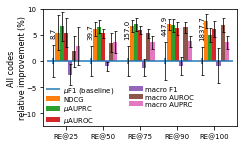

In [68]:
fig, ax = bar_plot_results((skl_results_long
                           .query('model=="Vanilla" and input_data=="Drugs, Sex, Age"')
                            .query('model_id==0')#.query('crossval_id==0')
                            .query('metric_name.str.startswith("RE@")')
                            .query('code_subset=="All codes" and code_level=="All"')),
                           "target_metric",
                           "metric_name",
                           values_subset=["overall_micro_F1", "overall_NDCG", "overall_micro_aucPR", "overall_micro_AUROC",
                                          "overall_macro_F1", "overall_macro_AUROC", "overall_macro_aucPR"],
                           groups_subset=["RE@25", 'RE@50',
                                          "RE@75", "RE@90", "RE@100"],
                           reference_row="overall_micro_F1",
                           reference_val='relative',
                           legend_kwargs={'loc': (0,-.012), 'ncol': 2},
                           abs_value_in_percent=False,
                           improvement_direction="min",
                           average=True,
                           values_legend_dict=metrics_pretty_names_dict
                           )
ax.set_ylabel("All codes\nrelative improvement (%)",labelpad=-5)
ax.set_ylim(-12.5,10)
#ax.set_title('RE@ All code levels')
fig.tight_layout()
if mpl.get_backend()=='pdf':
    # The inline backend distorts the scaling and outputs figures 
    # with wrong dimensions
    fig.savefig(plots_dir/"opt_metric_AllCodes.pdf")

### Fig S3: best target metric per level

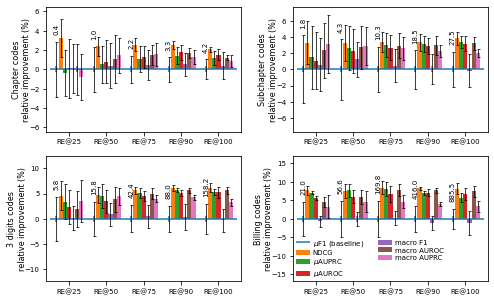

In [69]:
fig, axes = plt.subplots(2, 2)
for level, ax in zip(["Chapter", "Subchapter", "3 digits", "Billing"], axes.reshape(-1)):
    bar_plot_results((skl_results_long
                      .query('model=="Vanilla" and input_data=="Drugs, Sex, Age"')
                      .query('model_id==0')
                      .query('metric_name.str.startswith("RE@")')
                      .query('code_subset=="All codes" and code_level=="'+level+'"')),
                     "target_metric",
                     "metric_name",
                     values_subset=["overall_micro_F1", "overall_NDCG", "overall_micro_aucPR", "overall_micro_AUROC",
                                    "overall_macro_F1", "overall_macro_AUROC", "overall_macro_aucPR"],
                     groups_subset=["RE@25", 'RE@50',
                                    "RE@75", "RE@90", "RE@100"],
                     reference_row="overall_micro_F1",
                     reference_val='relative',
                     legend_kwargs={'loc': (0,0),'ncol':2},
                     abs_value_in_percent=False,
                     improvement_direction="min",
                     average=True,
                     axis=ax,
                    values_legend_dict=metrics_pretty_names_dict
                     )
    if level!="Billing":
        # Keep the legend only on the 4th plot to reduce clutter
        ax.get_legend().remove()
    #ax.set_title(level+" codes")
    ax.set_ylabel(level+" codes\nrelative improvement (%)",labelpad=-2)
fig.set_size_inches(dual_col_fig_size)
fig.tight_layout()
if mpl.get_backend()=='pdf':
    # The inline backend distorts the scaling and outputs figures 
    # with wrong dimensions
    fig.savefig(plots_dir/"opt_metric_perlevel.pdf")


### Fig 3: Multitask learning

In [9]:
ndcg_improve_title = "Relative NDCG improvement (%)"
methods_pretty_names = {"Vanilla": "Naive Multitask",
                        "multitask": "Re-weighted Multitask",
                        "focal": "Focal Loss",
                        "outL2reg": "L2 regularization",
                        "imbal": "IRW",
                        "imbalNorm": "IRNW",
                        "HierL2": "Hierarchical regularization",
                        "TreeMin": "TM loss",
                        "MCLoss": "MC loss",
                        "flatRollDown": "Roll Down",
                        "flatRollUp": "Roll Up"
                        }

In [10]:
plots_dir = get_project_root()/"docs/latex/overleaf/gfx/"
fig,ax = bar_plot_results((skl_results_long
                  .query('target_metric=="overall_NDCG"')
                  .query('metric_name=="NDCG" and input_data=="Drugs, Sex, Age" and code_subset=="All codes" and code_level!="All"')),
                    "model",
                     "code_level",
                    values_subset = ["Vanilla","Per level","multitask"],
                  reference_row="Vanilla",
                 reference_val='relative',
                    legend_kwargs={'loc':"lower left"},
                  improvement_direction="max",
                  average=True,
                  values_legend_dict=methods_pretty_names
                )
ax.set_ylim(-2,2)
ax.set_ylabel(ndcg_improve_title,labelpad=0)
#ax.set_title('NDCG')
fig.tight_layout()
if mpl.get_backend()=='pdf':
  # The inline backend distorts the scaling and outputs figures 
  # with wrong dimensions
  fig.savefig(plots_dir/"multitask_AllCodes.pdf")

### Fig 5: class imbalance correction

In [11]:
fig, ax = bar_plot_results(
    (skl_results_long
     .query('target_metric=="overall_NDCG"')
     .query('metric_name=="NDCG" and input_data=="Drugs, Sex, Age" and code_subset=="All codes"')),
    "model",
    "code_level",
    # values_subset = ["Vanilla","focal","imbal","imbalNorm"],
    values_subset=["Vanilla", "focal", "outL2reg", "imbal", "imbalNorm"],
    reference_row="Vanilla",
    reference_val='relative',
    legend_kwargs={'loc': (0, 0),
                   'ncol': 2
                   },
    improvement_direction="max",
    average=True,
    values_legend_dict=methods_pretty_names
)
ax.set_ylim(-2, 2)
ax.set_ylabel(ndcg_improve_title, labelpad=0)
#ax.set_title('NDCG')
fig.tight_layout()
if mpl.get_backend() == 'pdf':
  # The inline backend distorts the scaling and outputs figures
  # with wrong dimensions
  fig.savefig(plots_dir/"imbalance_AllCodes.pdf")


### Fig 4: HMC methods

In [12]:
fig, ax = bar_plot_results(
    (skl_results_long
     .query('target_metric=="overall_NDCG"')
     .query('metric_name=="NDCG" and input_data=="Drugs, Sex, Age" and code_subset=="All codes"')),
    "model",
    "code_level",
    #values_subset = ["Vanilla","TreeMin","MCLoss","flatRollDown","flatRollUp"],
    #values_subset = ["Vanilla","HierL2","TreeMin","MCLoss","flatRollDown","flatRollUp"],
    values_subset=[
        "Vanilla", "HierL2", "TreeMin", "MCLoss", "flatRollDown", "flatRollUp"],
    reference_row="Vanilla",
    reference_val='relative',
    legend_kwargs={'loc': (0, 0),
                   'ncol': 2
                   },
    improvement_direction="max",
    average=True,
    values_legend_dict=methods_pretty_names

)
ax.set_ylim(-2, 2)
ax.set_ylabel(ndcg_improve_title, labelpad=0)
fig.tight_layout()
if mpl.get_backend() == 'pdf':
  # The inline backend distorts the scaling and outputs figures
  # with wrong dimensions
  fig.savefig(plots_dir/"hmc_AllCodes.pdf")


### All methods, all levels RE (not in manuscript)

In [48]:
fig, axes = plt.subplots(1, 1)
plots_dir = get_project_root()/"docs/latex/overleaf/gfx/"
target_metric = "overall_NDCG"
for level, ax in zip(["All"], [axes]):
    fig, ax = bar_plot_results(
        (skl_results_long
         .query('target_metric=="'+target_metric+'"')
         #.query('model_id==0')
         .query('input_data=="Drugs, Sex, Age" and code_subset=="All codes"')
         .query('code_level=="'+level+'"')),
        "model",
        "metric_name",
        values_subset=["Vanilla", "multitask", "HierL2", "TreeMin", "MCLoss",
                       "focal", "outL2reg", "imbal", "imbalNorm", "flatRollDown", "flatRollUp"],
        groups_subset=["RE@25", 'RE@50', "RE@75", "RE@90", "RE@100"],
        reference_row="Vanilla",
        reference_val='relative',
        legend_kwargs={'loc': "lower left", 'ncol': 2},
        abs_value_in_percent=False,
        improvement_direction="min",
        average=True,
        axis=ax,
        values_legend_dict=methods_pretty_names
    )
    #ax.set_title(level)
    ax.set_ylabel("All codes \nrelative improvement (%)")

#fig.suptitle(target_metric)
fig.set_size_inches(dual_col_fig_size)
fig.tight_layout()
if mpl.get_backend() == 'pdf':
    # The inline backend distorts the scaling and outputs figures
    # with wrong dimensions
    fig.savefig(plots_dir/"all_methods_RE_Allcodes.pdf")


### Fig S5: All methods, per level RE

In [47]:
fig,axes = plt.subplots(2,2)
plots_dir = get_project_root()/"docs/latex/overleaf/gfx/"
target_metric = "overall_NDCG"
for level,ax in zip(["Chapter","Subchapter","3 digits","Billing"],axes.reshape(-1)):
    fig,ax = bar_plot_results((skl_results_long
                      .query('target_metric=="'+target_metric+'"')
                      #.query('model_id==0')
                       .query('input_data=="Drugs, Sex, Age" and code_subset=="All codes"')
                       .query('code_level=="'+level+'"')),
                        "model",
                         "metric_name",
                    values_subset = ["Vanilla","Per level","multitask","HierL2","TreeMin","MCLoss",
                    "focal","outL2reg","imbal","imbalNorm","flatRollDown","flatRollUp"],
                      groups_subset=["RE@25",'RE@50',"RE@75","RE@90","RE@100"],
                      reference_row="Vanilla",
                     reference_val='relative',
                        legend_kwargs={'loc':"best",'ncol':2},
                      abs_value_in_percent=False,
                      improvement_direction="min",
                      average=True,
                    axis = ax,
                    values_legend_dict=methods_pretty_names
                    )
    ax.text(.5,.9,level,
        horizontalalignment='center',
        transform=ax.transAxes)
    ax.set_ylabel("Relative improvement (%)")
    # Remove legend
    ax.get_legend().remove()
# Get legend labels from the last axis
handles, labels = ax.get_legend_handles_labels()
# Add a global legend for the figure
large_height_fig_size = (dual_col_fig_size[0],dual_col_fig_size[1]*1.4)
fig.set_size_inches(large_height_fig_size)
fig.legend(handles, labels,
           ncol=5, loc='lower center',
           borderaxespad=-.6,
           frameon=False)
#fig.suptitle(target_metric)

fig.tight_layout()
if mpl.get_backend() == 'pdf':
    # The inline backend distorts the scaling and outputs figures
    # with wrong dimensions
    fig.savefig(plots_dir/"all_methods_RE_perlevel.pdf")


#### Paired T tests for RE reduction with multitask

In [65]:
# Check whether differences in RE are significant between naive multitask and per level multitask
from scipy.stats import ttest_rel # paired t test
tmp = (skl_results_long
 .query('target_metric=="overall_NDCG"')
 .query('code_subset=="All codes"')
 .query('model.isin(["Vanilla","Per level"])')
 .query('metric_name.str.startswith("RE@")')
 .query('code_level!="All"')
 ).drop(columns=["target_metric",'input_data','model_id','code_subset'])

tmp = tmp.pivot(index=['metric_name','code_level','crossval_id'],
          columns='model',
          values='metric_value')
pvals = tmp.groupby(level=['metric_name','code_level']).apply(lambda x: ttest_rel(a=x['Vanilla'],b=x['Per level'],
                                                                                        alternative='two-sided').pvalue)
pvals

metric_name  code_level
RE@10        3 digits      0.656410
             Billing       0.217445
             Chapter       0.234473
             Subchapter    0.701420
RE@100       3 digits      0.157139
             Billing       0.009495
             Chapter       0.327324
             Subchapter    0.347741
RE@25        3 digits      0.208445
             Billing       0.158638
             Chapter       0.095687
             Subchapter    0.398124
RE@33        3 digits      0.207102
             Billing       0.194130
             Chapter       0.591996
             Subchapter    0.074378
RE@50        3 digits      0.663938
             Billing       0.085027
             Chapter       0.991810
             Subchapter    0.290222
RE@66        3 digits      0.128975
             Billing       0.043938
             Chapter       0.837657
             Subchapter    0.101531
RE@75        3 digits      0.123275
             Billing       0.035212
             Chapter       0.983653
    

In [66]:
pvals[pvals<.05]

metric_name  code_level
RE@100       Billing       0.009495
RE@66        Billing       0.043938
RE@75        Billing       0.035212
             Subchapter    0.004126
RE@90        Billing       0.000280
dtype: float64

In [63]:
tmp.groupby(level=['metric_name','code_level']).apply(lambda x: (x['Vanilla'] - x['Per level']).mean())

metric_name  code_level
RE@10        3 digits      -0.012823
             Billing       -0.306387
             Chapter       -0.002306
             Subchapter     0.004392
RE@100       3 digits      -2.492116
             Billing      -27.278219
             Chapter       -0.011745
             Subchapter    -0.184514
RE@25        3 digits      -0.043045
             Billing       -0.609257
             Chapter       -0.002492
             Subchapter    -0.009711
RE@33        3 digits      -0.048803
             Billing       -0.763115
             Chapter       -0.001971
             Subchapter    -0.018629
RE@50        3 digits      -0.037066
             Billing       -1.463397
             Chapter       -0.000091
             Subchapter    -0.029548
RE@66        3 digits      -0.281706
             Billing       -3.461922
             Chapter        0.003230
             Subchapter    -0.087680
RE@75        3 digits      -0.541335
             Billing       -5.080210
             C

## Averaged metrics correlations

### Fig S4: Spearman rank correlation between different metrics values and rank errors for different recall values

In [70]:
skl_results_long.head()

,metric_name,metric_value,code_level,model,target_metric,input_data,code_subset,model_id,crossval_id
0,micro_F1,0.455192,All,Vanilla,overall_macro_AUROC,"Drugs, Sex, Age",All codes,0,0
1,macro_F1,0.026901,All,multitask,overall_NDCG,"Drugs, Sex, Age",All codes,0,2
2,samples_F1,0.407974,All,multitask,overall_NDCG,"Drugs, Sex, Age",All codes,0,2
3,micro_AUROC,0.979523,All,multitask,overall_NDCG,"Drugs, Sex, Age",All codes,0,2
4,macro_AUROC,0.235360,All,multitask,overall_NDCG,"Drugs, Sex, Age",All codes,0,2


In [15]:
wide_skl_results = (skl_results_long
                    .query('code_subset=="All codes"')
                    #.query('model=="Vanilla"')
                    .query('code_level=="All"')
                    .pivot(index=('model','code_subset','input_data','target_metric','code_level','crossval_id'), columns='metric_name', values='metric_value'))
rank_errors = ['RE@10', 'RE@25', 'RE@33', 'RE@50', 'RE@66','RE@75', 'RE@90', 'RE@100']
other_metrics = list(set(wide_skl_results.columns)-set(rank_errors))

re_df = wide_skl_results.loc[:,rank_errors]
other_metrics_df = wide_skl_results.loc[:,other_metrics]

# Compute the matrix of Spearman correlation coefficients between metrics and RE@P
def compute_RE_correlations(x):
    return re_df.apply(lambda y: scipy.stats.spearmanr(x, y,nan_policy='omit').correlation,axis=0)
other_metrics_corr = other_metrics_df.apply(compute_RE_correlations,axis=0).transpose()

print("Number of models used to compute metrics correlations:" + str(len(wide_skl_results)))

Number of models used to compute metrics correlations:50


In [16]:
# Sort the rows of the metrics correlation according to the average correlation value
mean_row_corr = other_metrics_corr.mean(axis=1)
other_metrics_corr = other_metrics_corr.loc[mean_row_corr.sort_values(ascending=True).index,:]
# compute approximate spearman correlation coefficient: https://stats.stackexchange.com/questions/18887/how-to-calculate-a-confidence-interval-for-spearmans-rank-correlation

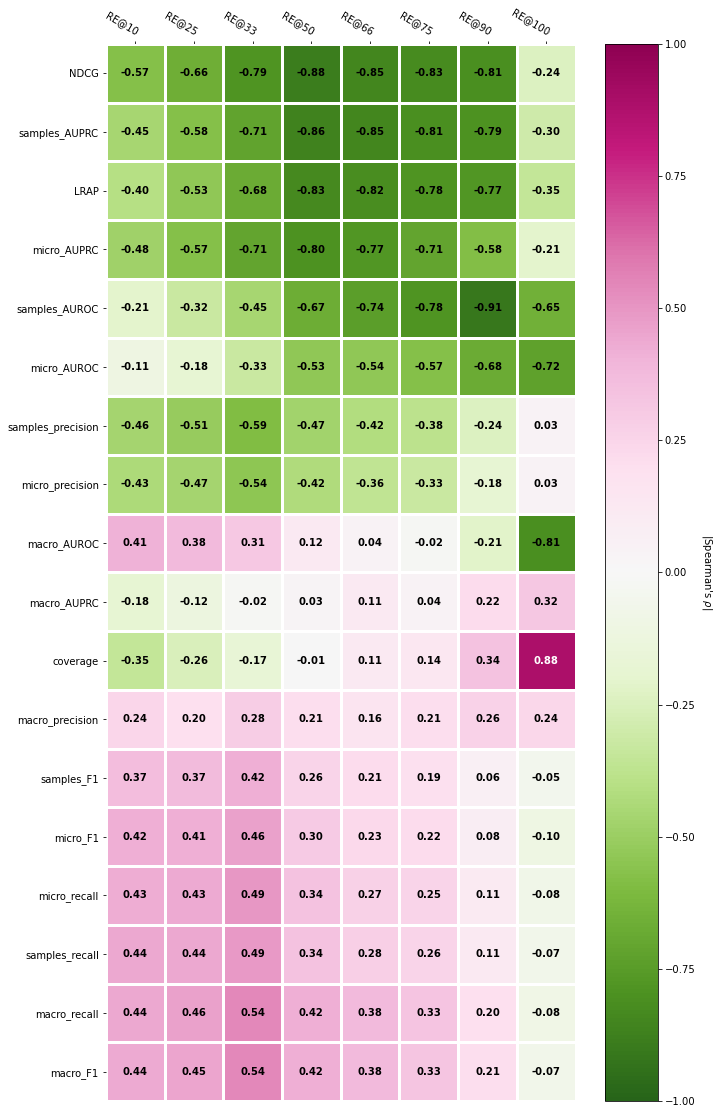

In [17]:
# from https://matplotlib.org/stable/gallery/images_contours_and_fields/image_annotated_heatmap.html#sphx-glr-gallery-images-contours-and-fields-image-annotated-heatmap-py
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]), labels=col_labels)
    ax.set_yticks(np.arange(data.shape[0]), labels=row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    import matplotlib
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

fig, ax = plt.subplots(figsize=(10,20))

#im, cbar = heatmap(np.abs(other_metrics_corr.to_numpy()), other_metrics_corr.index, other_metrics_corr.columns, ax=ax,
#                   cmap="YlGn", cbarlabel=r"|Spearman's $\rho$|",vmin=0, vmax=1)
im, cbar = heatmap(other_metrics_corr.to_numpy(), other_metrics_corr.index, other_metrics_corr.columns, ax=ax,
                   cmap="PiYG_r", cbarlabel=r"|Spearman's $\rho$|",vmin=-1, vmax=1,cbar_kw={'shrink':.745})
texts = annotate_heatmap(im, valfmt="{x:.2f}", threshold=.65, fontweight=560)

fig.tight_layout()
plt.show()
fig.savefig(plots_dir/"metrics_rankerrors_correlation.pdf")

# Models global ranking performance (RE@R)

In [3]:
predictions = pd.read_csv("/home/quentin/Projects/completion_pmsi/models/mimic-omop/sequentialNN_3/overall_NDCG/drugSexAge_AllCodes/best_models/1/"
                              +"predictions_test.csv.gz").set_index('visit_occurrence_id')
icd9_concepts = pd.read_csv(datadir / "icd9_concepts.csv.gz")
icd9_allcodes = icd9_concepts[icd9_concepts.concept_code.isin(predictions.columns)].concept_code
icd9_chapters = (icd9_concepts[icd9_concepts.concept_code.isin(predictions.columns)].query('concept_class_id=="Chapter"')
                    .concept_code)
icd9_subchapters = (icd9_concepts[icd9_concepts.concept_code.isin(predictions.columns)].query('concept_class_id=="SubChapter"')
                    .concept_code)
icd9_3dig = (icd9_concepts[icd9_concepts.concept_code.isin(predictions.columns)].query('concept_class_id.str.startswith("3-dig",'
                                 'na=False)')
             .concept_code)
icd9_billing = (
    icd9_concepts[icd9_concepts.concept_code.isin(predictions.columns)].query('concept_class_id.str.endswith("-dig billing code",'
                        'na=False)')
    .concept_code)
del predictions

In [2]:
def dummy_ranker(y_true_learn, y_true_test, pos_label=1):
    y_true_learn = np.asarray(y_true_learn)
    freq = (y_true_learn==pos_label).mean(axis=0)
    freq = freq.reshape((1,-1))
    return np.concatenate([freq]*y_true_test.shape[0],axis=0)

from sklearn.dummy import DummyClassifier

In [178]:
def rank_errors_at_K(y_true, y_score, k, pos_label=1):
    y_score = np.asarray(y_score)
    y_false = np.asarray(y_true)!=pos_label
    arg_sorted_scores = (-y_score).argsort(axis=1)
    sorted_errors = np.take_along_axis(y_false, arg_sorted_scores,axis=1)
    rank_errors = np.cumsum(sorted_errors, axis=1, dtype=np.float64)
    return rank_errors

def precision_at_recall(recall,precision_at_k, recall_at_k):
    if not isinstance(recall,float) and recall>1.0 or recall<0.0:
        return ValueError('recall value must be a numeric value between 0 and 1.')
    # Get the index of first rank achieving the recall value
    indices = np.argmax(recall_at_k>=recall, axis=1)
    # Get the precision a the given recall
    p_at_r = np.squeeze(np.take_along_axis(arr=precision_at_k,
                       indices=indices.reshape([-1,1]),
                       axis=1))
    p_at_r[np.any(np.isnan(recall_at_k),axis=1)] = np.nan
    return p_at_r
    
def get_positive_ranks(y_true,y_score,pos_label=1):
    y_score_arr = np.asarray(y_score)
    y_true_arr = np.asarray(y_true)==pos_label
    ranks = (-y_score_arr).argsort(axis=1).argsort(axis=1)+1 # guarantees all ranks>0
    pos_ind = np.nonzero(y_true_arr*ranks)
    ranks = ranks[pos_ind]
    
    if isinstance(y_score,pd.DataFrame):
        return pd.DataFrame({'index':y_score.index[pos_ind[0]],
                             "column":y_score.columns[pos_ind[1]],
                             "prediction_rank":ranks
                            })
    elif isinstance(y_true,pd.DataFrame):
        return pd.DataFrame({'index':y_true.index[pos_ind[0]],
                     "column":y_true.columns[pos_ind[1]],
                     "prediction_rank":ranks
                    })
    else:
        return pd.DataFrame({'row_id':y_score.index[pos_ind[0]],
                     "col_id":y_score.columns[pos_ind[1]],
                     "prediction_rank":ranks
                    })
def compute_predictions_ranks(y_score):
    y_score_arr = np.asarray(y_score)
    ranks = (-y_score_arr).argsort(axis=1).argsort(axis=1)+1 # guarantees all ranks>0
    if isinstance(y_score, pd.DataFrame):
        ranks = pd.DataFrame(ranks,columns=y_score.columns,index=y_score.index)
    return ranks


In [6]:
models_dir = get_modelsdir() / "mimic-omop/sequentialNN_3/overall_micro_aucPR/drugSexAge_AllCodes"
tables_dir = get_project_root()/"docs/latex/overleaf/tables/"

In [7]:
test_visits = pd.read_csv(datadir/'test_visits_id.csv.gz').squeeze()
train_visits = pd.read_csv(datadir/'train_visits_id.csv.gz').squeeze()
oh_diagnoses_df = pd.read_parquet(datadir/"oh_diagnoses_rollup.parquet").set_index('visit_occurrence_id')
test_oh_diagnoses_df = oh_diagnoses_df.loc[test_visits,:]
train_oh_diagnoses_df = oh_diagnoses_df.loc[train_visits,:]
gc.collect()

259

In [8]:
# Train a dummy classifier
dummy_classifier = DummyClassifier(strategy='prior')
dummy_classifier.fit(X=np.empty_like(train_oh_diagnoses_df),y=train_oh_diagnoses_df.to_numpy())
dummy_pred = dummy_classifier.predict(X=np.empty_like(test_oh_diagnoses_df))
dummy_probas = dummy_ranker(train_oh_diagnoses_df,test_oh_diagnoses_df,pos_label=1)
dummy_predictions = pd.DataFrame(dummy_probas,columns=test_oh_diagnoses_df.columns,index=test_oh_diagnoses_df.index)
del train_oh_diagnoses_df, oh_diagnoses_df
gc.collect()

0

### Fig. 1d: Recall at K all codes 

In [196]:
# Compare actual recall for models learned on different code sets
code_subset = icd9_billing
max_K = 50
res = {}
oh_diagnoses_df = pd.read_parquet(datadir/"oh_diagnoses_rollup.parquet").set_index('visit_occurrence_id')
for crossval_suff in ['','_1','_2']:
    test_visits = pd.read_csv(datadir/("test_visits_id"+crossval_suff+".csv.gz")).squeeze()
    train_visits = pd.read_csv(datadir/("train_visits_id"+crossval_suff+".csv.gz")).squeeze()
    test_oh_diagnoses_df = oh_diagnoses_df.loc[test_visits,:]
    train_oh_diagnoses_df = oh_diagnoses_df.loc[train_visits,:]
    predictions = pd.read_csv("/home/quentin/Projects/completion_pmsi/models/mimic-omop/sequentialNN_3/overall_micro_F1/drugSexAge_AllCodes"
                                +crossval_suff+"/best_models/1/"
                                +"predictions_test.csv.gz").set_index('visit_occurrence_id')
    predictions_subset = pd.read_csv("/home/quentin/Projects/completion_pmsi/models/mimic-omop/sequentialNN_3/overall_micro_F1/drugSexAge_Sagi"
                                +crossval_suff+"/best_models/1/"
                                +"predictions_test.csv.gz").set_index('visit_occurrence_id')
    missing_columns = predictions.columns[~predictions.columns.isin(predictions_subset.columns)]


    dummy_classifier = DummyClassifier(strategy='prior')
    dummy_classifier.fit(X=np.empty_like(train_oh_diagnoses_df),y=train_oh_diagnoses_df.to_numpy())
    dummy_pred = dummy_classifier.predict(X=np.empty_like(test_oh_diagnoses_df))
    dummy_probas = dummy_ranker(train_oh_diagnoses_df,test_oh_diagnoses_df,pos_label=1)
    dummy_predictions = pd.DataFrame(dummy_probas,columns=test_oh_diagnoses_df.columns,index=test_oh_diagnoses_df.index)

    # Add back the missing columns and assign them 0 probability
    predictions_subset.loc[:,missing_columns] = 0.0
    predictions_subset = predictions_subset[predictions.columns] # reorder columns
    for pred,label in zip([predictions_subset, predictions, dummy_predictions],
                        ['Cherry Picked Training', 'All Codes Training', "Dummy"]):
        r_precision,recall = precision_recall_at_K(test_oh_diagnoses_df.loc[:,code_subset], pred.loc[:,code_subset], k=None, pos_label=1, rectified_precision=True)
        mean_recall_K = np.nanmean(recall,axis=0)
        q1_recall_K = np.nanpercentile(recall,25,axis=0)
        q3_recall_K = np.nanpercentile(recall,75,axis=0)
        df = pd.DataFrame({'mean_R@K'+crossval_suff:mean_recall_K,
                                    'q1_R@K'+crossval_suff:q1_recall_K,
                                    'q3_R@K'+crossval_suff:q3_recall_K})
        if res.get(label) is None:
            res[label] = df
        else:
            res[label] = pd.concat([res[label],df],axis=1)

Max Recall@K difference:5.51%
All Recall@K: 
4     0.255480
9     0.368433
19    0.488827
29    0.559845
49    0.644533
Name: mean, dtype: float64
Sagi Recall@K: 
4     0.249294
9     0.350027
19    0.455884
29    0.518238
49    0.589346
Name: mean, dtype: float64


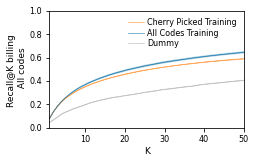

In [198]:
for label,col in zip(['Cherry Picked Training', 'All Codes Training', "Dummy"],
                    ['#FF800E','#006BA4','#ABABAB']):
    df = res[label]
    for stat in ['mean_R@K','q1_R@K','q3_R@K']:
        cols = df.columns.str.startswith(stat)
        mean_stat = df.loc[:,cols].aggregate(['mean','sem'],axis=1)
        if stat=='mean_R@K':
            plt.plot(range(1,len(mean_stat['mean'])+1), mean_stat['mean'],label=label,color=col,linewidth=.5)
            plt.fill_between(range(1,len(mean_stat['mean'])+1),mean_stat['mean']-mean_stat['sem'],mean_stat['mean']+mean_stat['sem'],alpha=.3,color=col)
        else:
            pass
            #plt.plot(range(1,len(mean_stat['mean'])+1), mean_stat['mean'],color=col,linestyle='--')
            #plt.fill_between(range(1,len(mean_stat['mean'])+1),mean_stat['mean']-mean_stat['sem'],mean_stat['mean']+mean_stat['sem'],alpha=.3,color=col)
    # keep computation for further analysis
        if stat == 'mean_R@K':
            if label=='Cherry Picked Training':
                sagi_recall_k = mean_stat['mean'][0:max_K]
            elif label=='All Codes Training':
                all_recall_k = mean_stat['mean'][0:max_K]
plt.gcf().set_size_inches(single_col_fig_size)
plt.xlim(1,max_K)
plt.legend(frameon=False)
#plt.title('Recall@K for billing codes on the complete code set')
plt.ylabel('Recall@K billing \n All codes')
plt.ylim(0,1)
plt.xlabel('K')
plt.savefig(plots_dir/"recallatK_uF1_allcodes.pdf")
print("Max Recall@K difference:"+str(np.abs((sagi_recall_k-all_recall_k)).max()*100)[0:4]+'%')
print("All Recall@K: ")
print(all_recall_k[[4,9,19,29,49]])
print("Sagi Recall@K: ")
print(sagi_recall_k[[4,9,19,29,49]])
del sagi_recall_k, all_recall_k

### Fig. 1c: Recall at K cherry picked F1

In [185]:
# Compare actual recall on the cherry picked for models learned
# on different code sets
code_subset = icd9_billing
max_K = 50
res = {}
oh_diagnoses_df = pd.read_parquet(datadir/"oh_diagnoses_rollup.parquet").set_index('visit_occurrence_id')
for crossval_suff in ['','_1','_2']:
    test_visits = pd.read_csv(datadir/("test_visits_id"+crossval_suff+".csv.gz")).squeeze()
    train_visits = pd.read_csv(datadir/("train_visits_id"+crossval_suff+".csv.gz")).squeeze()
    test_oh_diagnoses_df = oh_diagnoses_df.loc[test_visits,:]
    train_oh_diagnoses_df = oh_diagnoses_df.loc[train_visits,:]
    predictions = pd.read_csv("/home/quentin/Projects/completion_pmsi/models/mimic-omop/sequentialNN_3/overall_micro_F1/drugSexAge_AllCodes"
                                +crossval_suff+"/best_models/1/"
                                +"predictions_test.csv.gz").set_index('visit_occurrence_id')
    predictions_subset = pd.read_csv("/home/quentin/Projects/completion_pmsi/models/mimic-omop/sequentialNN_3/overall_micro_F1/drugSexAge_Sagi"
                                +crossval_suff+"/best_models/1/"
                                +"predictions_test.csv.gz").set_index('visit_occurrence_id')
    missing_columns = predictions.columns[~predictions.columns.isin(predictions_subset.columns)]


    dummy_classifier = DummyClassifier(strategy='prior')
    dummy_classifier.fit(X=np.empty_like(train_oh_diagnoses_df),y=train_oh_diagnoses_df.to_numpy())
    dummy_pred = dummy_classifier.predict(X=np.empty_like(test_oh_diagnoses_df))
    dummy_probas = dummy_ranker(train_oh_diagnoses_df,test_oh_diagnoses_df,pos_label=1)
    dummy_predictions = pd.DataFrame(dummy_probas,columns=test_oh_diagnoses_df.columns,index=test_oh_diagnoses_df.index)

    code_subset = code_subset[code_subset.isin(predictions_subset.columns)]
    for pred,label in zip([predictions_subset, predictions, dummy_predictions],
                        ['Cherry Picked Training', 'All Codes Training', "Dummy"]):
        r_precision,recall = precision_recall_at_K(test_oh_diagnoses_df.loc[:,code_subset], pred.loc[:,code_subset], k=None, pos_label=1, rectified_precision=True)
        mean_recall_K = np.nanmean(recall,axis=0)
        q1_recall_K = np.nanpercentile(recall,25,axis=0)
        q3_recall_K = np.nanpercentile(recall,75,axis=0)
        df = pd.DataFrame({'mean_R@K'+crossval_suff:mean_recall_K,
                                    'q1_R@K'+crossval_suff:q1_recall_K,
                                    'q3_R@K'+crossval_suff:q3_recall_K})
        if res.get(label) is None:
            res[label] = df
        else:
            res[label] = pd.concat([res[label],df],axis=1)

Max Recall@K difference:0.70%
Min Recall@K difference:0.17%


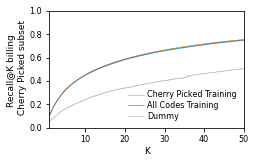

In [195]:
for label,col in zip(['Cherry Picked Training', 'All Codes Training', "Dummy"],
                    ['#FF800E','#006BA4','#ABABAB']):
    df = res[label]
    for stat in ['mean_R@K','q1_R@K','q3_R@K']:
        cols = df.columns.str.startswith(stat)
        mean_stat = df.loc[:,cols].aggregate(['mean','sem'],axis=1)
        if stat=='mean_R@K':
            plt.plot(range(1,len(mean_stat['mean'])+1), mean_stat['mean'],label=label,color=col,linewidth=.5)
            plt.fill_between(range(1,len(mean_stat['mean'])+1),mean_stat['mean']-mean_stat['sem'],mean_stat['mean']+mean_stat['sem'],
            alpha=.3,color=col,linewidth=.5)
        else:
            pass
            #plt.plot(range(1,len(mean_stat['mean'])+1), mean_stat['mean'],color=col,linestyle='--')
            #plt.fill_between(range(1,len(mean_stat['mean'])+1),mean_stat['mean']-mean_stat['sem'],mean_stat['mean']+mean_stat['sem'],alpha=.3,color=col)
    # keep computation for further analysis
        if stat == 'mean_R@K':
            if label=='Cherry Picked Training':
                sagi_recall_k = mean_stat['mean'][0:max_K]
            elif label=="All Codes Training":
                all_recall_k = mean_stat['mean'][0:max_K]
plt.xlim(1,max_K)
plt.legend(frameon=False,loc='lower right')
#plt.title('Recall@K for billing codes on Sagi code set')
plt.ylabel('Recall@K billing \n Cherry Picked subset')
plt.ylim(0,1)
plt.xlabel('K')
plt.savefig(plots_dir/"recallatK_uF1_Sagicodes.pdf")
print("Max Recall@K difference:"+str((sagi_recall_k-all_recall_k).max()*100)[0:4]+"%")
print("Min Recall@K difference:"+str((sagi_recall_k-all_recall_k).min()*100)[0:4]+"%")
del sagi_recall_k, all_recall_k

## Fig. 6: Recall@K summary at billing level

In [11]:
# Compare actual recall for models learned on different code sets
code_subset = icd9_billing
max_K = 50
res = {}
oh_diagnoses_df = pd.read_parquet(datadir/"oh_diagnoses_rollup.parquet").set_index('visit_occurrence_id')
for crossval_suff in ['','_1','_2']:
    test_visits = pd.read_csv(datadir/("test_visits_id"+crossval_suff+".csv.gz")).squeeze()
    train_visits = pd.read_csv(datadir/("train_visits_id"+crossval_suff+".csv.gz")).squeeze()
    test_oh_diagnoses_df = oh_diagnoses_df.loc[test_visits,:]
    train_oh_diagnoses_df = oh_diagnoses_df.loc[train_visits,:]
    predictions_F1 = pd.read_csv("/home/quentin/Projects/completion_pmsi/models/mimic-omop/sequentialNN_3/overall_micro_F1/drugSexAge_AllCodes"
                                +crossval_suff+"/best_models/1/"
                                +"predictions_test.csv.gz").set_index('visit_occurrence_id')
    predictions_NDCG = pd.read_csv("/home/quentin/Projects/completion_pmsi/models/mimic-omop/sequentialNN_3/overall_NDCG/drugSexAge_AllCodes"
                            +crossval_suff+"/best_models/1/"
                            +"predictions_test.csv.gz").set_index('visit_occurrence_id')
    predictions_subset = pd.read_csv("/home/quentin/Projects/completion_pmsi/models/mimic-omop/sequentialNN_3/overall_micro_F1/drugSexAge_Sagi"
                                +crossval_suff+"/best_models/1/"
                                +"predictions_test.csv.gz").set_index('visit_occurrence_id')
    missing_columns = predictions_F1.columns[~predictions_F1.columns.isin(predictions_subset.columns)]

    dummy_probas = dummy_ranker(train_oh_diagnoses_df,test_oh_diagnoses_df,pos_label=1)
    dummy_predictions = pd.DataFrame(dummy_probas,columns=test_oh_diagnoses_df.columns,index=test_oh_diagnoses_df.index)

    # Add back the missing columns and assign them 0 probability
    predictions_subset.loc[:,missing_columns] = 0.0
    predictions_subset = predictions_subset[predictions_F1.columns] # reorder columns
    for pred,label in zip([predictions_subset, predictions_F1, predictions_NDCG, dummy_predictions],
                        [r'Cherry Picked Training $\mu$F1', r'All Codes Training $\mu$F1', 'All Codes Training NDCG', "Dummy"]):
        r_precision,recall = precision_recall_at_K(test_oh_diagnoses_df.loc[:,code_subset], pred.loc[:,code_subset], k=None, pos_label=1, rectified_precision=True)
        mean_recall_K = np.nanmean(recall,axis=0)
        q1_recall_K = np.nanpercentile(recall,25,axis=0)
        q3_recall_K = np.nanpercentile(recall,75,axis=0)
        df = pd.DataFrame({'mean_R@K'+crossval_suff:mean_recall_K,
                                    'q1_R@K'+crossval_suff:q1_recall_K,
                                    'q3_R@K'+crossval_suff:q3_recall_K})
        if res.get(label) is None:
            res[label] = df
        else:
            res[label] = pd.concat([res[label],df],axis=1)


In [12]:
# Plot main text figure
plt.figure()
for label,col in zip(['All Codes Training NDCG', r'All Codes Training $\mu$F1', r'Cherry Picked Training $\mu$F1', "Dummy"],
                    ['#b600bc', '#006BA4', '#FF800E','#ABABAB']):
    df = res[label]
    for stat in ['mean_R@K']:
        cols = df.columns.str.startswith(stat)
        mean_stat = df.loc[:,cols].aggregate(['mean','sem'],axis=1)
        if stat=='mean_R@K':
            plt.plot(range(1,len(mean_stat['mean'])+1), mean_stat['mean'],
                     label=label,color=col,linewidth=.5)
            plt.fill_between(range(1,len(mean_stat['mean'])+1),
                             mean_stat['mean']-mean_stat['sem'],
                             mean_stat['mean']+mean_stat['sem'],
                             alpha=.3,color=col)

    # keep computation for further analysis
        if stat == 'mean_R@K':
            if label=='All Codes Training NDCG':
                best_recall_k = mean_stat['mean'][0:max_K]
            elif label==r'Cherry Picked Training $\mu$F1':
                cherry_f1_recall_k = mean_stat['mean'][0:max_K]
                
plt.gcf().set_size_inches(single_col_fig_size)
plt.xlim(1,max_K)
plt.legend(frameon=False)
#plt.title('Recall@K for billing codes on the complete code set')
plt.ylabel('Average Recall@K billing')
plt.ylim(0,1)
plt.xlabel('K')
if mpl.get_backend()=='pdf':
    # The inline backend distorts the scaling and outputs figures 
    # with wrong dimensions
    plt.savefig(plots_dir/"recallatK_bestmodel.pdf")
ks = [4,9,14,19,24,29,49]
print("Best model recall@K:")
print([ks,best_recall_k[ks]])
print("Best model recall@K:")
print([ks,cherry_f1_recall_k[ks]])

Best model recall@K:
[[4, 9, 15, 19, 24, 29, 49], 4     0.261025
9     0.377330
15    0.460006
19    0.500021
24    0.538463
29    0.570452
49    0.657491
Name: mean, dtype: float64]
Best model recall@K:
[[4, 9, 15, 19, 24, 29, 49], 4     0.249294
9     0.350027
15    0.421880
19    0.455884
24    0.490826
29    0.518238
49    0.589346
Name: mean, dtype: float64]


In [13]:
plt.figure()
for label,col in zip(['All Codes Training NDCG', r'All Codes Training $\mu$F1', r'Cherry Picked Training $\mu$F1', "Dummy"],
                    ['#b600bc', '#006BA4', '#FF800E','#ABABAB']):
    df = res[label]
    for stat,linestyle in zip(['mean_R@K','q1_R@K','q3_R@K'],
                              ['-',':','-.']):
        cols = df.columns.str.startswith(stat)
        mean_stat = df.loc[:,cols].aggregate(['mean','sem'],axis=1)
        
        plt.plot(range(1,len(mean_stat['mean'])+1), mean_stat['mean'],
                    label=(label if stat=='mean_R@K' else None),
                    color=col,linewidth=.5,
                    linestyle=linestyle)
        plt.fill_between(range(1,len(mean_stat['mean'])+1),
                            mean_stat['mean']-mean_stat['sem'],
                            mean_stat['mean']+mean_stat['sem'],
                            alpha=.3,color=col)

        # keep computation for further analysis
        if stat == 'mean_R@K':
            if label=='Cherry Picked Training':
                sagi_recall_k = mean_stat['mean'][0:max_K]
            elif label=='All Codes Training':
                all_recall_k = mean_stat['mean'][0:max_K]
plt.gcf().set_size_inches(dual_col_fig_size)
plt.xlim(1,max_K)
# Add a first legend for colors
color_legend = plt.legend(frameon=False)
plt.gca().add_artist(color_legend)

# Add a second legend for linestyle
lines = [plt.plot([],[],linestyle=linestyle,
                  label=label,color='k',
                  linewidth=.5)[0] for linestyle,label in zip(['-',':','-.'],
                                                              ['Average','Q1','Q3'])]
plt.legend(handles=lines,frameon=False)

#plt.title('Recall@K for billing codes on the complete code set')
plt.ylabel('Recall@K billing')
plt.ylim(0,1)
plt.xlabel('K')
if mpl.get_backend()=='pdf':
    # The inline backend distorts the scaling and outputs figures 
    # with wrong dimensions
    plt.savefig(plots_dir/"recallatK_bestmodel_Q1Q3.pdf")

## Fig. S7: Recall@K summary at 3 digits level

In [14]:
# Compare actual recall for models learned on different code sets
code_subset = icd9_3dig
max_K = 50
res = {}
oh_diagnoses_df = pd.read_parquet(datadir/"oh_diagnoses_rollup.parquet").set_index('visit_occurrence_id')
for crossval_suff in ['','_1','_2']:
    test_visits = pd.read_csv(datadir/("test_visits_id"+crossval_suff+".csv.gz")).squeeze()
    train_visits = pd.read_csv(datadir/("train_visits_id"+crossval_suff+".csv.gz")).squeeze()
    test_oh_diagnoses_df = oh_diagnoses_df.loc[test_visits,:]
    train_oh_diagnoses_df = oh_diagnoses_df.loc[train_visits,:]
    predictions_F1 = pd.read_csv("/home/quentin/Projects/completion_pmsi/models/mimic-omop/sequentialNN_3/overall_micro_F1/drugSexAge_AllCodes"
                                +crossval_suff+"/best_models/1/"
                                +"predictions_test.csv.gz").set_index('visit_occurrence_id')
    predictions_NDCG = pd.read_csv("/home/quentin/Projects/completion_pmsi/models/mimic-omop/sequentialNN_3/overall_NDCG/drugSexAge_AllCodes"
                            +crossval_suff+"/best_models/1/"
                            +"predictions_test.csv.gz").set_index('visit_occurrence_id')
    predictions_subset = pd.read_csv("/home/quentin/Projects/completion_pmsi/models/mimic-omop/sequentialNN_3/overall_micro_F1/drugSexAge_Sagi"
                                +crossval_suff+"/best_models/1/"
                                +"predictions_test.csv.gz").set_index('visit_occurrence_id')
    missing_columns = predictions_F1.columns[~predictions_F1.columns.isin(predictions_subset.columns)]

    dummy_probas = dummy_ranker(train_oh_diagnoses_df,test_oh_diagnoses_df,pos_label=1)
    dummy_predictions = pd.DataFrame(dummy_probas,columns=test_oh_diagnoses_df.columns,index=test_oh_diagnoses_df.index)

    # Add back the missing columns and assign them 0 probability
    predictions_subset.loc[:,missing_columns] = 0.0
    predictions_subset = predictions_subset[predictions_F1.columns] # reorder columns
    for pred,label in zip([predictions_subset, predictions_F1, predictions_NDCG, dummy_predictions],
                        [r'Cherry Picked Training $\mu$F1', r'All Codes Training $\mu$F1', 'All Codes Training NDCG', "Dummy"]):
        r_precision,recall = precision_recall_at_K(test_oh_diagnoses_df.loc[:,code_subset], pred.loc[:,code_subset], k=None, pos_label=1, rectified_precision=True)
        mean_recall_K = np.nanmean(recall,axis=0)
        q1_recall_K = np.nanpercentile(recall,25,axis=0)
        q3_recall_K = np.nanpercentile(recall,75,axis=0)
        df = pd.DataFrame({'mean_R@K'+crossval_suff:mean_recall_K,
                                    'q1_R@K'+crossval_suff:q1_recall_K,
                                    'q3_R@K'+crossval_suff:q3_recall_K})
        if res.get(label) is None:
            res[label] = df
        else:
            res[label] = pd.concat([res[label],df],axis=1)

In [10]:
# Plot main text figure
plt.figure()
for label,col in zip(['All Codes Training NDCG', r'All Codes Training $\mu$F1', r'Cherry Picked Training $\mu$F1', "Dummy"],
                    ['#b600bc', '#006BA4', '#FF800E','#ABABAB']):
    df = res[label]
    for stat in ['mean_R@K']:
        cols = df.columns.str.startswith(stat)
        mean_stat = df.loc[:,cols].aggregate(['mean','sem'],axis=1)
        if stat=='mean_R@K':
            plt.plot(range(1,len(mean_stat['mean'])+1), mean_stat['mean'],
                     label=label,color=col,linewidth=.5)
            plt.fill_between(range(1,len(mean_stat['mean'])+1),
                             mean_stat['mean']-mean_stat['sem'],
                             mean_stat['mean']+mean_stat['sem'],
                             alpha=.3,color=col)

    # keep computation for further analysis
        if stat == 'mean_R@K':
            if label=='All Codes Training NDCG':
                best_recall_k = mean_stat['mean'][0:max_K]
            elif label==r'Cherry Picked Training $\mu$F1':
                cherry_f1_recall_k = mean_stat['mean'][0:max_K]
                
plt.gcf().set_size_inches(single_col_fig_size)
plt.xlim(1,max_K)
plt.legend(frameon=False)
#plt.title('Recall@K for billing codes on the complete code set')
plt.ylabel('Average Recall@K 3-digits')
plt.ylim(0,1)
plt.xlabel('K')
if mpl.get_backend()=='pdf':
    # The inline backend distorts the scaling and outputs figures 
    # with wrong dimensions
    plt.savefig(plots_dir/"recallatK_bestmodel_3dig.pdf")
ks = [4,9,14,19,24,29,49]
print("Best model recall@K:")
print(best_recall_k[ks])
print("Best model recall@K:")
print(cherry_f1_recall_k[ks])

Best model recall@K:
4     0.342303
9     0.481591
15    0.579209
19    0.624796
24    0.670722
29    0.706593
49    0.799066
Name: mean, dtype: float64
Best model recall@K:
4     0.270630
9     0.383631
15    0.461141
19    0.498365
24    0.532485
29    0.558910
49    0.624691
Name: mean, dtype: float64


# Performance metrics comparison with other papers

Reconstruct missing dev and training sets model predictions to compute the adaptive threshold performances. Requires a bit of fiddling to the missing keras serialization functions in the current version of `keras_utils`. As the missing objects are losses and metrics their missingness does not influence predictions.  

In [ ]:
from numpy.testing import assert_almost_equal
# Ignore missing metrics serializers warning
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
# Generate predictions for the development set using the learned models
oh_ingredients_df = (pd.read_parquet(datadir / "oh_ingredients.parquet")
                     .set_index('visit_occurrence_id'))
oh_diagnoses_df_sample = pd.read_csv(
    datadir/"oh_diagnoses_rollup.csv.gz",nrows=1).set_index('visit_occurrence_id')

age_sex_df = pd.read_csv(datadir / "visits_agesex.csv.gz",
                         usecols=['visit_occurrence_id', 'age', 'sex_F'],
                         dtype={'age': 'float64',
                                'sex': 'uint8',
                                'visit_occurrence_id': 'uint64'},
                         index_col='visit_occurrence_id')

for crossval_suffix,crossval_id in zip(['', '_1', '_2'],[0,1,2]):
#for crossval_suffix, crossval_id in zip(['_1', '_2'], [1, 2]):
    test_visits_ids = pd.read_csv(
        datadir/('test_visits_id'+crossval_suffix+'.csv.gz')).squeeze()
    dev_visits_ids = pd.read_csv(
        datadir/('dev_visits_id'+crossval_suffix+'.csv.gz')).squeeze()
    train_visits_ids = pd.read_csv(
        datadir/('train_visits_id'+crossval_suffix+'.csv.gz')).squeeze()
    dev_oh_ingredients_df = oh_ingredients_df.loc[dev_visits_ids, :]
    dev_oh_ingredients_df = pd.merge(age_sex_df, dev_oh_ingredients_df,
                                     left_index=True,
                                     right_index=True,
                                     how='right')
    test_oh_ingredients_df = oh_ingredients_df.loc[test_visits_ids, :]
    test_oh_ingredients_df = pd.merge(age_sex_df, test_oh_ingredients_df,
                                     left_index=True,
                                     right_index=True,
                                     how='right')
    train_oh_ingredients_df = oh_ingredients_df.loc[train_visits_ids, :]
    train_oh_ingredients_df = pd.merge(age_sex_df, train_oh_ingredients_df,
                                     left_index=True,
                                     right_index=True,
                                     how='right')
    test_predictions = pd.read_csv(
        (models_dir /
         ('overall_micro_aucPR/drugSexAge_AllCodes'+crossval_suffix) /
         'best_models/1/predictions_test.csv.gz')).set_index('visit_occurrence_id')
    model = tf.keras.models.load_model(
        (models_dir /
         ('overall_micro_aucPR/drugSexAge_AllCodes'+crossval_suffix) /
         'best_models/1/model'),
        compile=False  # Needed since metrics serializers are missing
    )
    model.compile()
    model.summary()
    # Make a sanity check
    y_pred_test = model.predict(
        x=test_oh_ingredients_df.loc[test_visits_ids, :]#.to_numpy(),)
    )
    #assert_almost_equal(y_pred_test,test_predictions.loc[test_visits_ids, :].to_numpy(),decimal=2)
    
    y_pred_dev = model.predict(
        x=dev_oh_ingredients_df.loc[dev_visits_ids, :].to_numpy(),)
    y_pred_dev = pd.DataFrame(y_pred_dev, columns=oh_diagnoses_df_sample.columns,
                        index=dev_visits_ids)
    y_pred_dev.to_csv((models_dir /
                    ('overall_micro_aucPR/drugSexAge_AllCodes'+crossval_suffix) /
                    'best_models/1/predictions_dev.csv.gz'),
                          header=True,
                          index=True,
                          index_label="visit_occurrence_id")

    y_pred_train = model.predict(
        x=train_oh_ingredients_df.loc[train_visits_ids, :].to_numpy(),)
    y_pred_train = pd.DataFrame(y_pred_train, columns=oh_diagnoses_df_sample.columns,
                        index=train_visits_ids)
    y_pred_train.to_csv((models_dir /
                    ('overall_micro_aucPR/drugSexAge_AllCodes'+crossval_suffix) /
                    'best_models/1/predictions_train.csv.gz'),
                          header=True,
                          index=True,
                          index_label="visit_occurrence_id")

### Table S4 hard classification results vs Hansen et al

In [18]:
# Build a table of F1,R,P scores to compare with and Hansen et al 2022
from project_miscellaneous import filter_Sagi_diagnoses
import sklearn.metrics as skmet


oh_diagnoses_df = pd.read_parquet(
    datadir/"oh_diagnoses_rollup.parquet").set_index('visit_occurrence_id')
base_dir = "/home/quentin/Projects/completion_pmsi/models/mimic-omop/sequentialNN_3/overall_micro_F1/"
results_df = pd.DataFrame(
    columns=('Experiment', 'Code level', 'Metric', "Value", "crossval_id"))

for exp_dir, exp_name in zip(['drugSexAge_Sagi', 'drugSexAge_AllCodes'],
                             ['Filtered codes learning', 'All codes learning']):
    for crossval_suffix,crossval_id in zip(['', '_1', '_2'],[0,1,2]):
        sagi_codes = filter_Sagi_diagnoses(oh_diagnoses_df=oh_diagnoses_df)
        oh_diagnoses_sagi_df = oh_diagnoses_df.loc[:, ~oh_diagnoses_df.columns.isin(sagi_codes)]
        visit_ids = pd.read_csv(
            datadir/('test_visits_id'+crossval_suffix+'.csv.gz')).squeeze()
        test_oh_diagnoses_df = oh_diagnoses_sagi_df.loc[visit_ids,:].sort_index(
        )
        test_predictions = pd.read_csv(
            base_dir+exp_dir+crossval_suffix+"/best_models/1/predictions_test.csv.gz").set_index('visit_occurrence_id')
        test_predictions = test_predictions.loc[:, ~test_predictions.columns.isin(sagi_codes)].sort_index() # make sure index is sorted

        for code_set, code_set_name in zip([icd9_chapters, icd9_subchapters, icd9_3dig, icd9_billing],
                                           ['Chapter', 'Subchapter',
                                               '3 digits', 'Billing (raw)']
                                           ):
            y_true = test_oh_diagnoses_df.loc[:,test_oh_diagnoses_df.columns.isin(code_set)].to_numpy()
            y_pred = test_predictions.loc[:,test_predictions.columns.isin(code_set)].to_numpy() > .5
                                           
            f1 = (skmet.f1_score(y_true=y_true,
                                 y_pred=y_pred,
                                 average='micro',
                                 pos_label=1))
            prec = (skmet.precision_score(y_true=y_true,
                                          y_pred=y_pred,
                                          average='micro',
                                          pos_label=1))
            rec = (skmet.recall_score(y_true=y_true,
                                      y_pred=y_pred,
                                      average='micro',
                                      pos_label=1))
            results_df = pd.concat([results_df, pd.DataFrame({'Experiment': exp_name,
                                                             'Code level': code_set_name,
                                                             'Metric': ['µF1', 'Precision', 'Recall'],
                                                             'Value': [f1, prec, rec],
                                                             'crossval_id': crossval_id
                                                             })])


Compute performance using the adaptive threshold based on dev set.

In [ ]:
from project_miscellaneous import filter_Sagi_diagnoses
import sklearn.metrics as skmet

oh_diagnoses_df = pd.read_parquet(
    datadir/"oh_diagnoses_rollup.parquet").set_index('visit_occurrence_id')
icd9_concepts = pd.read_csv(datadir / "icd9_concepts.csv.gz")
icd9_allcodes = icd9_concepts[icd9_concepts.concept_code.isin(oh_diagnoses_df.columns)].concept_code
icd9_chapters = icd9_concepts[icd9_concepts.concept_code.isin(oh_diagnoses_df.columns)].query('concept_class_id=="Chapter"').concept_code
icd9_subchapters = (icd9_concepts[icd9_concepts.concept_code.isin(oh_diagnoses_df.columns)].query('concept_class_id=="SubChapter"')
                    .concept_code)
icd9_3dig = (icd9_concepts[icd9_concepts.concept_code.isin(oh_diagnoses_df.columns)].query('concept_class_id.str.startswith("3-dig",'
                                'na=False)').concept_code)
icd9_4dig = (icd9_concepts[icd9_concepts.concept_code.isin(oh_diagnoses_df.columns)].query('concept_class_id.str.startswith("4-dig",'
                                'na=False)').concept_code)
icd9_5dig = (icd9_concepts[icd9_concepts.concept_code.isin(oh_diagnoses_df.columns)].query('concept_class_id.str.startswith("5-dig",'
                                'na=False)').concept_code)
icd9_billing = (
    icd9_concepts[icd9_concepts.concept_code.isin(oh_diagnoses_df.columns)].query('concept_class_id.str.endswith("-dig billing code",'
                        'na=False)').concept_code)

adaptive_thresh_results_df = pd.DataFrame(
        columns=('Experiment','crossval_id', 'Code level', 'Metric', "Value"))

for crossval_suffix,crossval_id in zip(['', '_1', '_2'],[0,1,2]):
# for crossval_suffix, crossval_id in zip(['_1', '_2'], [1, 2]):
    base_dir = "/home/quentin/Projects/completion_pmsi/models/mimic-omop/sequentialNN_3/overall_micro_aucPR/drugSexAge_AllCodes"+crossval_suffix

    test_visits_ids = pd.read_csv(
        datadir/('test_visits_id'+crossval_suffix+'.csv.gz')).squeeze()
    sagi_codes = filter_Sagi_diagnoses(oh_diagnoses_df=oh_diagnoses_df)
    #sagi_codes = pd.Series(dtype='str')
    test_oh_diagnoses_df = oh_diagnoses_df.loc[test_visits_ids,~oh_diagnoses_df.columns.isin(sagi_codes)].sort_index()
    test_predictions = pd.read_csv(
            base_dir+"/best_models/1/predictions_test.csv.gz").set_index('visit_occurrence_id')
    test_predictions = test_predictions.loc[:, ~test_predictions.columns.isin(sagi_codes)].sort_index() # make sure index is sorted

    dev_visits_ids = pd.read_csv(
        datadir/('dev_visits_id'+crossval_suffix+'.csv.gz')).squeeze()
    dev_oh_diagnoses_df = oh_diagnoses_df.loc[dev_visits_ids,~oh_diagnoses_df.columns.isin(sagi_codes)].sort_index()
    dev_predictions = pd.read_csv(
            base_dir+"/best_models/1/predictions_dev.csv.gz").set_index('visit_occurrence_id')
    dev_predictions = dev_predictions.loc[:, ~dev_predictions.columns.isin(sagi_codes)].sort_index() # make sure index is sorted

    for code_set, code_set_name in zip([icd9_chapters, icd9_subchapters, icd9_3dig, icd9_billing],
                                            ['Chapter', 'Subchapter',
                                                '3 digits', 'Billing (raw)']
                                            ):
        y_true_dev = dev_oh_diagnoses_df.loc[:,dev_oh_diagnoses_df.columns.isin(code_set)].to_numpy()
        y_pred_dev = dev_predictions.loc[:,dev_predictions.columns.isin(code_set)].to_numpy()

        precision, recall, thresholds = skmet.precision_recall_curve(y_true_dev.ravel(), y_pred_dev.ravel(),
                                                                     pos_label=1, )
        f1_scores = 2*recall*precision/(recall+precision)
        print()
        best_threshold = thresholds[np.argmax(f1_scores)]

        y_true_test = test_oh_diagnoses_df.loc[:,test_oh_diagnoses_df.columns.isin(code_set)].to_numpy()
        y_pred_test = test_predictions.loc[:,test_predictions.columns.isin(code_set)].to_numpy() > best_threshold

        precision = skmet.precision_score(y_true_test.ravel(), y_pred_test.ravel(),pos_label=1)
        recall = skmet.recall_score(y_true_test.ravel(), y_pred_test.ravel(),pos_label=1)
        f1_score = skmet.f1_score(y_true_test.ravel(), y_pred_test.ravel(),pos_label=1)

        adaptive_thresh_results_df = pd.concat([adaptive_thresh_results_df, pd.DataFrame({'Experiment': "Adaptive Threshold",
                                                          'crossval_id': crossval_id,
                                                          'Code level': code_set_name,
                                                          'Metric': ['µF1', 'Precision', 'Recall'],
                                                          'Value': [f1_score, precision, recall],
                                                          'Threshold': best_threshold
                                                          })])
#print(adaptive_thresh_results_df)

In [28]:
# Compute mean and standard error over our experiments
tmp = pd.concat([results_df,adaptive_thresh_results_df.drop(columns='Threshold')],axis=0)
tmp = tmp.drop(columns='crossval_id').groupby(by=['Experiment','Code level','Metric']).aggregate([np.mean,np.std])*100
tmp = tmp.droplevel(level=0,axis=1)
tmp['stderr'] = tmp['std']/np.sqrt(3)
tmp.drop(columns='std',inplace=True)
tmp['Value'] = tmp.apply(lambda x: str(x['mean'])[0:5] + ' $\pm$ ' + str(x['stderr'])[0:4],axis=1)
tmp.reset_index(inplace=True)
tmp.drop(columns=['mean','stderr'],inplace=True)

# Concatenate Hansen et al values
# Make a DF containing results reported in Hansen et al 2022 table 3
hansen_results_df = pd.DataFrame({'Code level': ['Chapter']*3+['Subchapter']*3+['3 digits']*3+['Billing (raw)']*3,
                                  'Metric': ['Precision', 'Recall', 'µF1']*4,
                                  'Value': [68.46, 69.27, 68.86,
                                                   58.05, 57.21, 57.63,
                                                   48.45, 47.19, 47.81,
                                                   36.98, 36.26, 36.62],
                                  'Experiment':'Hansen et al.'
                                  })
hansen_results_df = hansen_results_df.astype('str')

# # Make a DF containing results reported in Sagi et al 2020 table 1
# sagi_results_df = pd.DataFrame({'Code level': ['Chapter']*3+['Subchapter']*3+['3 digits']*3+['Billing (raw)']*3,
#                                   'Metric': ['Precision', 'Recall', 'µF1']*4,
#                                   'Value': [78.3,58.2,66.8,
#                                             60.9,43.0,50.4,
#                                             56.6,31.5,40.5,
#                                             49.9,18.8,27.3],
#                                   'Experiment':'Sagi et al.'
#                                   })
# sagi_results_df = sagi_results_df.astype('str')

# hansen_compare_df = pd.concat([tmp,sagi_results_df,hansen_results_df])
tmp = pd.concat([tmp,hansen_results_df])

# # Pivot the table to a wider one
# hansen_compare_df_wide = hansen_compare_df.pivot(index=['Code level','Metric'],columns='Experiment').droplevel(level=0,axis=1)
# # reorder rows and cols
# hansen_compare_df_wide = hansen_compare_df_wide.loc[['Chapter','Subchapter','3 digits','Billing (raw)']]
# hansen_compare_df_wide = hansen_compare_df_wide.loc[:,['All codes learning','Filtered codes learning','Sagi et al.','Hansen et al.']]
# hansen_compare_df_wide.style.to_latex(buf=tables_dir/"hardclassif_scores.tex",
#                 environment='void',hrules=True,clines="skip-last;index",column_format='llrrrr')  

# Pivot the table to a wider one
hardclassif_cherry_compare_df = tmp.pivot(index=['Code level','Metric'],columns='Experiment').droplevel(level=0,axis=1)
# reorder rows and cols
hardclassif_cherry_compare_df = hardclassif_cherry_compare_df.loc[['Chapter','Subchapter','3 digits','Billing (raw)']]
hardclassif_cherry_compare_df = hardclassif_cherry_compare_df.loc[:,['All codes learning','Filtered codes learning','Adaptive Threshold','Hansen et al.']]
hardclassif_cherry_compare_df.style.to_latex(buf=tables_dir/"hardclassif_scores.tex",
                environment='void',hrules=True,clines="skip-last;index",column_format='llrrrr')  

In [29]:
hardclassif_cherry_compare_df

Experiment              All codes learning Filtered codes learning  \
Code level    Metric                                                 
Chapter       Precision   73.65 $\pm$ 0.32        73.58 $\pm$ 0.37   
              Recall      68.03 $\pm$ 0.19        67.98 $\pm$ 0.60   
              µF1         70.73 $\pm$ 0.04        70.66 $\pm$ 0.16   
Subchapter    Precision   66.51 $\pm$ 0.49        67.24 $\pm$ 0.02   
              Recall      49.36 $\pm$ 0.11        49.10 $\pm$ 0.49   
              µF1         56.66 $\pm$ 0.12        56.75 $\pm$ 0.32   
3 digits      Precision   60.55 $\pm$ 0.44        61.73 $\pm$ 0.48   
              Recall      33.13 $\pm$ 0.05        32.39 $\pm$ 0.47   
              µF1         42.83 $\pm$ 0.06        42.48 $\pm$ 0.30   
Billing (raw) Precision   54.39 $\pm$ 0.58        55.67 $\pm$ 0.59   
              Recall      22.06 $\pm$ 0.11        21.50 $\pm$ 0.34   
              µF1         31.39 $\pm$ 0.05        31.02 $\pm$ 0.28   

Experiment              Adaptive Threshold Hansen et al.  
Code level    Metric                                      
Chapter       Precision   68.15 $\pm$ 0.61         68.46  
              Recall      75.61 $\pm$ 0.54         69.27  
              µF1         71.67 $\pm$ 0.11         68.86  
Subchapter    Precision   57.39 $\pm$ 0.47         58.05  
              Recall      60.80 $\pm$ 0.07         57.21  
              µF1         59.04 $\pm$ 0.22         57.63  
3 digits      Precision   46.82 $\pm$ 1.00         48.45  
              Recall      47.65 $\pm$ 1.08         47.19  
              µF1         47.18 $\pm$ 0.07         47.81  
Billing (raw) Precision   37.90 $\pm$ 0.54         36.98  
              Recall      38.22 $\pm$ 0.59         36.26  
              µF1         38.04 $\pm$ 0.01         36.62

### Table S6 AUROC comparison with Malakouti and Hauskretch

In [49]:
# Build a table of F1,R,P scores to compare with Malakouti and Hauskretech
from project_miscellaneous import filter_Sagi_diagnoses
import sklearn.metrics as skmet


oh_diagnoses_df = pd.read_parquet(
    datadir/"oh_diagnoses_rollup.parquet").set_index('visit_occurrence_id')
base_dir = "/home/quentin/Projects/completion_pmsi/models/mimic-omop/sequentialNN_3/overall_macro_AUROC/"
results_df = pd.DataFrame(
    columns=('Experiment', 'Metric', "Value", "crossval_id"))

exp_dir, exp_name =('drugSexAge_AllCodes','All codes learning')
frequent_codes = oh_diagnoses_df.columns[oh_diagnoses_df.sum(axis=0)/float(len(oh_diagnoses_df)) >= 0.01]
for crossval_suffix,crossval_id in zip(['', '_1', '_2'],[0,1,2]):
    visit_ids = pd.read_csv(
        datadir/('test_visits_id'+crossval_suffix+'.csv.gz')).squeeze()
    test_oh_diagnoses_df = oh_diagnoses_df.loc[visit_ids,frequent_codes].sort_index()
    test_predictions = pd.read_csv(
        base_dir+exp_dir+crossval_suffix+"/best_models/1/predictions_test.csv.gz").set_index('visit_occurrence_id')
    test_predictions = test_predictions.loc[:, frequent_codes].sort_index() # make sure index is sorted

    y_true = test_oh_diagnoses_df.to_numpy()
    y_pred = test_predictions.to_numpy()
                                    
    MAUROC = macro_averaged_AUROC(y_true=y_true,
                                    probas_pred=y_pred,
                                    pos_label=1)
    MAUPRC = macro_averaged_auc_PR(y_true=y_true,
                                    probas_pred=y_pred,
                                    pos_label=1)
    results_df = pd.concat([results_df, pd.DataFrame({'Experiment': exp_name,
                                                        'Metric': ['macro AUROC', 'macro AUPRC'],
                                                        'Value': [MAUROC,MAUPRC],
                                                        'crossval_id': crossval_id
                                                        })])

In [50]:
malakouti_compare_df = results_df.groupby('Metric').aggregate({'Value' : ('mean','sem')})
malakouti_compare_df = malakouti_compare_df.droplevel(level=0,axis=1)
print(malakouti_compare_df)
print(len(frequent_codes))

                 mean       sem
Metric                         
macro AUPRC  0.302209  0.001554
macro AUROC  0.867473  0.000594
592


In [51]:
malakouti_compare_df['Naive multitask ('+str(len(frequent_codes))+' codes)'] = malakouti_compare_df.apply(lambda x: str(x['mean']*100)[0:5] + ' $\pm$ ' + str(x['sem']*100)[0:4],axis=1)
malakouti_compare_df.drop(columns=['mean','sem'],inplace=True)
malakouti_compare_df['Malakouti and Hauskrecht (696 codes)'] = ['18.5','75.1']
malakouti_compare_df.style.to_latex(buf=tables_dir/"softclassif_scores_malakouti.tex",
                environment='void',hrules=True,clines="skip-last;index",column_format='lrr') 

In [52]:
malakouti_compare_df

,Naive multitask (592 codes),Malakouti and Hauskrecht (696 codes)
Metric,,
macro AUPRC,30.22 $\pm$ 0.15,18.5
macro AUROC,86.74 $\pm$ 0.05,75.1


### Performance metrics computed on different code subsets

In [ ]:
from project_miscellaneous import filter_Sagi_diagnoses
import sklearn.metrics as skmet
oh_diagnoses_df = pd.read_parquet(
    datadir/"oh_diagnoses_rollup.parquet").set_index('visit_occurrence_id')

icd9_concepts = pd.read_csv(datadir / "icd9_concepts.csv.gz")
icd9_allcodes = icd9_concepts[icd9_concepts.concept_code.isin(oh_diagnoses_df.columns)].concept_code
icd9_chapters = icd9_concepts[icd9_concepts.concept_code.isin(oh_diagnoses_df.columns)].query('concept_class_id=="Chapter"').concept_code
icd9_subchapters = (icd9_concepts[icd9_concepts.concept_code.isin(oh_diagnoses_df.columns)].query('concept_class_id=="SubChapter"')
                    .concept_code)
icd9_3dig = (icd9_concepts[icd9_concepts.concept_code.isin(oh_diagnoses_df.columns)].query('concept_class_id.str.startswith("3-dig",'
                                'na=False)').concept_code)
icd9_4dig = (icd9_concepts[icd9_concepts.concept_code.isin(oh_diagnoses_df.columns)].query('concept_class_id.str.startswith("4-dig",'
                                'na=False)').concept_code)
icd9_5dig = (icd9_concepts[icd9_concepts.concept_code.isin(oh_diagnoses_df.columns)].query('concept_class_id.str.startswith("5-dig",'
                                'na=False)').concept_code)
icd9_billing = (
    icd9_concepts[icd9_concepts.concept_code.isin(oh_diagnoses_df.columns)].query('concept_class_id.str.endswith("-dig billing code",'
                        'na=False)').concept_code)


base_dir = "/home/quentin/Projects/completion_pmsi/models/mimic-omop/sequentialNN_3/"

metrics_func_dict = {
    'micro_AUROC':lambda y_true,y_score: skmet.roc_auc_score(y_true=y_true, y_score=y_score, average='micro'),
    'macro_AUROC':lambda y_true,y_score: macro_averaged_AUROC(*filter_no_positive_label(y_true, y_score),pos_label=1),
    
    'micro_AUPRC': lambda y_true,y_score: micro_averaged_auc_PR(y_true=y_true, probas_pred=y_score, pos_label=1),
    'macro_AUPRC': lambda y_true,y_score: macro_averaged_auc_PR(*filter_no_positive_label(y_true, y_score), pos_label=1),
    
    'NDCG': lambda y_true,y_score: skmet.ndcg_score(y_true=y_true,y_score=y_score, k=None),

    'NDCG@15': lambda y_true,y_score: skmet.ndcg_score(y_true=y_true,y_score=y_score, k=15),
}
for p in [25,50,75,100]:
    metrics_func_dict['RE@'+str(p)] = lambda y_true,y_score,q=p: np.nanmean(kumet.rank_errors_at_percentile(y_true=y_true, y_pred=y_score, q=q, no_true_label_value=None).numpy())

n_occurrences = oh_diagnoses_df.sum(axis=0)
code_filters_dict = {
    'Top50': lambda x: x.sort_values()[-50:].index,
    'None': lambda x: x.index,
}
results_df = pd.DataFrame()

def compute_metrics(truth_df,predictions_df, metrics_list):

    predictions_df.sort_index(ascending=True,inplace=True)
    truth_df.sort_index(ascending=True,inplace=True)

    metrics_df = pd.DataFrame()

    for code_subset, code_subset_name in zip([icd9_allcodes, icd9_chapters, icd9_subchapters, icd9_3dig, icd9_billing],
                                            ['All', 'Chapter', 'Subchapter', '3 digits', 'Billing']):
        for filter_name,filter_func in code_filters_dict.items():
            if filter_name=="Top50" and (code_subset_name in ['Chapter','Subchapter']):
                continue
            code_subset_dict = {"Hierarchy level":[code_subset_name], "Filter":[filter_name]}
            filtered_codes = filter_func(n_occurrences.loc[code_subset])
            for metric in metrics_list:
                code_subset_dict[metric] = [metrics_func_dict[metric](truth_df.loc[:,filtered_codes].to_numpy(),
                                                                    predictions_df.loc[:,filtered_codes].to_numpy())]
            metrics_df = pd.concat([metrics_df, pd.DataFrame(code_subset_dict)])
    return metrics_df

for crossval_suffix,crossval_id in zip(['', '_1', '_2'],[0,1,2]):
    visit_ids = pd.read_csv(datadir/('test_visits_id'+crossval_suffix+'.csv.gz')).squeeze()
    test_oh_diagnoses_df = oh_diagnoses_df.loc[visit_ids,:]
    metrics_df = pd.DataFrame()
    # Compute RE,NDCG and NDCG@15 on NDCG experiment
    test_predictions = pd.read_csv(
        base_dir+"overall_NDCG/drugSexAge_AllCodes"+crossval_suffix
        +"/best_models/1/predictions_test.csv.gz").set_index('visit_occurrence_id')
    tmp = compute_metrics(test_oh_diagnoses_df,test_predictions,
                ['NDCG','NDCG@15','RE@25','RE@50','RE@75','RE@100'])
    metrics_df = pd.concat([metrics_df, tmp])
    # Compute micro AUROC
    test_predictions = pd.read_csv(
        base_dir+"overall_micro_AUROC/drugSexAge_AllCodes"+crossval_suffix
        +"/best_models/1/predictions_test.csv.gz").set_index('visit_occurrence_id')
    tmp = compute_metrics(test_oh_diagnoses_df,test_predictions,
            ['micro_AUROC'])
    metrics_df = pd.merge(metrics_df, tmp,on=["Hierarchy level","Filter"])
    # Compute macro AUROC
    test_predictions = pd.read_csv(
        base_dir+"overall_macro_AUROC/drugSexAge_AllCodes"+crossval_suffix
        +"/best_models/1/predictions_test.csv.gz").set_index('visit_occurrence_id')
    tmp = compute_metrics(test_oh_diagnoses_df,test_predictions,
                ['macro_AUROC'])
    metrics_df = pd.merge(metrics_df, tmp,on=["Hierarchy level","Filter"])
    # Compute micro AUPRC and LRAP
    test_predictions = pd.read_csv(
        base_dir+"overall_micro_aucPR/drugSexAge_AllCodes"+crossval_suffix
        +"/best_models/1/predictions_test.csv.gz").set_index('visit_occurrence_id')
    tmp = compute_metrics(test_oh_diagnoses_df,test_predictions,
                ['micro_AUPRC'])
    metrics_df = pd.merge(metrics_df, tmp,on=["Hierarchy level","Filter"])
    # Compute macro AUPRC
    test_predictions = pd.read_csv(
        base_dir+"overall_macro_aucPR/drugSexAge_AllCodes"+crossval_suffix
        +"/best_models/1/predictions_test.csv.gz").set_index('visit_occurrence_id')
    tmp = compute_metrics(test_oh_diagnoses_df,test_predictions,
                ['macro_AUPRC'])
    metrics_df = pd.merge(metrics_df, tmp,on=["Hierarchy level","Filter"])
    
    metrics_df['crossval_id'] = crossval_id
    results_df = pd.concat([results_df,metrics_df])
results_df.to_csv(tables_dir/'performance_metrics_persubset.csv',index=False)

In [37]:
results_df = pd.read_csv(tables_dir/'performance_metrics_persubset.csv',index_col=['Filter','Hierarchy level'])
results_df

NDCG   NDCG@15      RE@25      RE@50       RE@75  \
Filter Hierarchy level                                                         
Top50  All              0.905674  0.802586   1.352283   3.626995    7.883311   
None   All              0.830641  0.745933   8.648289  37.653492  148.101910   
       Chapter          0.924145  0.918710   0.393832   0.975772    2.115584   
       Subchapter       0.839523  0.738461   1.678969   4.104698    9.825030   
Top50  3 digits         0.786003  0.710546   1.718675   3.576439    7.147665   
None   3 digits         0.754107  0.596264   5.472575  14.877092   39.930580   
Top50  Billing          0.631120  0.573224   2.410466   4.590089    8.538312   
None   Billing          0.608781  0.437473  19.504261  52.090378  155.010570   
Top50  All              0.905154  0.803104   1.315453   3.483554    7.796192   
None   All              0.829885  0.745552   8.251551  37.995000  148.247850   
       Chapter          0.921804  0.914997   0.420400   1.008202    2.164458   
       Subchapter       0.839107  0.736686   1.813536   4.388395   10.234887   
Top50  3 digits         0.790386  0.713955   1.704117   3.603575    7.206663   
None   3 digits         0.755212  0.595242   5.818787  15.578311   40.556843   
Top50  Billing          0.643243  0.586910   2.207820   4.275404    8.243769   
None   Billing          0.614398  0.441022  19.716946  54.278923  160.595520   
Top50  All              0.907414  0.804094   1.265869   3.497906    7.778929   
None   All              0.832280  0.749098   7.657939  36.260914  143.128650   
       Chapter          0.924012  0.917680   0.398622   0.979377    2.124000   
       Subchapter       0.840912  0.739286   1.665875   4.096562    9.871790   
Top50  3 digits         0.790038  0.713875   1.725744   3.627865    7.299743   
None   3 digits         0.756531  0.597066   5.256750  14.762240   39.508210   
Top50  Billing          0.644399  0.585921   2.219843   4.403768    8.581594   
None   Billing          0.614019  0.440548  18.830270  50.504300  150.752200   

                             RE@100  micro_AUROC  macro_AUROC  micro_AUPRC  \
Filter Hierarchy level                                                       
Top50  All                17.318040     0.871219     0.849181     0.752291   
None   All              1660.959700     0.983218     0.849517     0.500958   
       Chapter             4.072876     0.893717     0.848209     0.806640   
       Subchapter         26.213955     0.948834     0.852442     0.621387   
Top50  3 digits           13.874050     0.893614     0.857560     0.602602   
None   3 digits          147.303590     0.969501     0.856241     0.454996   
Top50  Billing            15.415603     0.890304     0.853319     0.494618   
None   Billing           792.124500     0.976287     0.847834     0.298843   
Top50  All                17.123400     0.870141     0.848532     0.753655   
None   All              1685.589500     0.982994     0.846022     0.496879   
       Chapter             4.102955     0.891672     0.845961     0.803031   
       Subchapter         26.910828     0.948050     0.856852     0.617963   
Top50  3 digits           14.054821     0.891835     0.857295     0.596412   
None   3 digits          151.469600     0.969405     0.852328     0.449465   
Top50  Billing            15.155574     0.891302     0.853952     0.496044   
None   Billing           811.021200     0.975898     0.845674     0.298157   
Top50  All                17.225260     0.869723     0.847168     0.752601   
None   All              1742.779900     0.983087     0.842807     0.499792   
       Chapter             4.107685     0.893504     0.846220     0.804858   
       Subchapter         26.292868     0.949449     0.857856     0.622994   
Top50  3 digits           14.136432     0.890604     0.854967     0.594260   
None   3 digits          146.466600     0.969747     0.847802     0.452350   
Top50  Billing            15.585254     0.888106     0.849949     0.487074 

#### Table S7 and S8: ranking and soft classification performance metrics on different subsets

In [ ]:
results_df = pd.read_csv(tables_dir/'performance_metrics_persubset.csv',index_col=['Filter','Hierarchy level'])
ranking_metrics = ['NDCG','NDCG@15','RE@25','RE@50','RE@75','RE@100']
soft_classif_metrics = ["micro_AUROC", "macro_AUROC", "micro_AUPRC","macro_AUPRC"]
non_RE_cols = results_df.columns[~results_df.columns.str.startswith('RE@')]
results_df.loc[:,non_RE_cols]*=100
results_df = results_df.reset_index(drop=False).melt(id_vars=['Filter','Hierarchy level','crossval_id'],var_name='metric',value_name='value')
results_df = results_df.drop(columns='crossval_id').groupby(by=["Filter",'Hierarchy level','metric']).aggregate(['mean','sem'])
results_df = results_df.droplevel(level=0,axis=1)
results_df['value'] = results_df.apply(lambda x: str(x['mean'])[0:5] + ' $\pm$ ' + str(x['sem'])[0:4],axis=1)
results_df = results_df.drop(columns=['mean','sem']).reset_index()
results_df = results_df.rename(columns={"metric":"Metric"})
results_df = results_df.pivot(index=["Filter","Hierarchy level"],columns="Metric", values='value')
results_df = results_df.reindex(["Chapter","Subchapter","3 digits","Billing","All"], level="Hierarchy level")

# All performance metrics
results_df.style.to_latex(buf=tables_dir/"perf_persubset.tex",
                environment='void',hrules=True,clines="skip-last;index",column_format='llrrrrrrrrrr')
# Table S7
results_df.loc[:,ranking_metrics].style.to_latex(buf=tables_dir/"ranking_perf_persubset.tex",
                environment='void',hrules=True,clines="skip-last;index",column_format='llrrrrrr')

# Table S8
results_classif_df = results_df.loc[:,soft_classif_metrics]
results_classif_df.columns = results_classif_df.columns.str.replace(pat='micro_',repl="$\mu$",regex=False)
results_classif_df.columns = results_classif_df.columns.str.replace(pat='macro_',repl="macro ",regex=False)
results_classif_df.style.to_latex(buf=tables_dir/"softclassif_perf_persubset.tex",
                environment='void',hrules=True,clines="skip-last;index",column_format='llrrrr')

### LIG-doctor, Rodrigues Jr et al 2021: number of ICD codes in the reported subset 

In [25]:
visit_patient_table = pd.read_csv(get_datadir()/"mimic-omop/visit_occurrence.csv.gz",
                                  usecols=('visit_occurrence_id','person_id'))
# Extract the visit_occurrence_id for patients with more than 1 stay
mul_stay_person_id = visit_patient_table.person_id[visit_patient_table.person_id.duplicated()].unique()
print("Number of patients with >= 2 stays: " + str(len(mul_stay_person_id)))
print("vs 7483 reported in Rodrigues et al, after filtering for negative "\
      "duration of stay and stays with 0 ICD codes attached.")
mul_stay_visit_patient  = visit_patient_table.loc[
      visit_patient_table.person_id.isin(mul_stay_person_id),
      :]
print("Number of corresponding visits: "+str(len(mul_stay_visit_patient)))
print("vs 19911 reported in Rodrigues et al, after filtering for negative "\
      "duration of stay and stays with 0 ICD codes attached.")


Number of patients with >= 2 stays: 7537
vs 7483 reported in Rodrigues et al, after filtering for negative duration of stay and stays with 0 ICD codes attached.
Number of corresponding visits: 19993
vs 19911 reported in Rodrigues et al, after filtering for negative duration of stay and stays with 0 ICD codes attached.


In [29]:
# Check the number of resulting ICD diagnoses
oh_diagnoses_df = pd.read_parquet(datadir/"oh_diagnoses_rollup.parquet").set_index('visit_occurrence_id')
oh_diagnoses_df = oh_diagnoses_df.loc[mul_stay_visit_patient.visit_occurrence_id,:]
icd9_concepts = pd.read_csv(datadir / "icd9_concepts.csv.gz")
icd9_allcodes = icd9_concepts.concept_code
icd9_chapters = icd9_concepts.query('concept_class_id=="Chapter"').concept_code
icd9_subchapters = (icd9_concepts.query('concept_class_id=="SubChapter"').concept_code)
icd9_3dig = (icd9_concepts.query('concept_class_id.str.startswith("3-dig",na=False)').concept_code)
icd9_4dig = (icd9_concepts.query('concept_class_id.str.startswith("4-dig",na=False)').concept_code)
icd9_5dig = (icd9_concepts.query('concept_class_id.str.startswith("5-dig",na=False)').concept_code)
icd9_billing = (icd9_concepts.query('concept_class_id.str.endswith("-dig billing code",na=False)').concept_code)
# Build the table containing the number of unique codes
n_codes_df = pd.DataFrame()
for code_set,name in zip([icd9_chapters,icd9_subchapters,icd9_3dig,icd9_4dig,icd9_5dig,icd9_billing,icd9_allcodes],
                            ['Chapters','Subchapters','3 digits','4 digits','5 digits','Billing','All levels']):
    tmp_df = pd.DataFrame({'ICD9-CM':len(code_set),
                            'MIMIC III Rodrigues':sum(oh_diagnoses_df.loc[:,oh_diagnoses_df.columns.isin(code_set)].sum(axis=0)>=1),
                            },index=[name])
    n_codes_df = pd.concat([n_codes_df,tmp_df],axis=0)
#n_codes_df.style.format(precision=2).to_latex(buf=tables_dir/"unique_codes_perlevel.tex",
#                environment='void',hrules=True,clines="skip-last;index",column_format='lrrr')
n_codes_df

,ICD9-CM,MIMIC III Rodrigues
Chapters,19,19
Subchapters,154,148
3 digits,1234,941
4 digits,7473,3224
5 digits,8846,2519
Billing,12167,4093
All levels,17726,6851


This doesn't agree at any level with the 855 ICD codes reported in the Rodrigues et al paper.

In [35]:
# Check the number of ICD9 CSS mapping see if it equals 855 from the Rodrigues paper
# retro engineered from: https://github.com/jfrjunio/LIG-Doctor/blob/master/preprocess_mimiciii.py
# And the corresponding file: https://github.com/jfrjunio/LIG-Doctor/blob/master/icd9_to_css_dictionary
import pickle
icd9TOCCS_Map = pickle.load(open(get_datadir()/'LIG_doctor_ICD-CCS_map/icd9_to_css_dictionary','rb'))
print('-Total number (complete set) of ICD9 codes (diag + proc): ' + str(len(set(icd9TOCCS_Map.keys()))))

-Total number (complete set) of ICD9 codes (diag + proc): 19020


In [76]:
# Check how many diagnoses in the filtered stay are in the CCS map
ccs_icd9_keys = pd.Series(icd9TOCCS_Map.keys())
ccs_icd9_keys = ccs_icd9_keys.str.rstrip(' ')
ccs_icd9_keys = set(ccs_icd9_keys)
diagnoses_in_map = ("D"+(oh_diagnoses_df.columns[
    oh_diagnoses_df.sum(axis=0)>=1
    ].to_series()
 .str.replace('.','',regex=False)
 .str.replace('-','',regex=False)
 )).isin(ccs_icd9_keys)

print("Multi stay unique ICD9 Diagnoses in CCS map: " + str(diagnoses_in_map.sum()))
for code_set,name in zip([icd9_chapters,icd9_subchapters,icd9_3dig,icd9_4dig,icd9_5dig,icd9_billing,icd9_allcodes],
                            ['Chapters','Subchapters','3 digits','4 digits','5 digits','Billing','All levels']):
    print("Multi stay unique ICD9 "+name+" Diagnoses in CCS map: " 
          + str(diagnoses_in_map[diagnoses_in_map.index.isin(code_set)].sum()))

Multi stay unique ICD9 Diagnoses in CCS map: 5137
Multi stay unique ICD9 Chapters Diagnoses in CCS map: 0
Multi stay unique ICD9 Subchapters Diagnoses in CCS map: 0
Multi stay unique ICD9 3 digits Diagnoses in CCS map: 98
Multi stay unique ICD9 4 digits Diagnoses in CCS map: 2520
Multi stay unique ICD9 5 digits Diagnoses in CCS map: 2519
Multi stay unique ICD9 Billing Diagnoses in CCS map: 4093
Multi stay unique ICD9 All levels Diagnoses in CCS map: 5137


# Information extracted beyond code frequency

### Fig. 1b: Positive vs negative examples rank ratios

In [ ]:
# Compute the relative difference of ranks between positive and negative examples
""" oh_diagnoses_df = pd.read_parquet(datadir/"oh_diagnoses_rollup.parquet").set_index('visit_occurrence_id')
test_visits = pd.read_csv(datadir/'test_visits_id.csv.gz').squeeze()
test_oh_diagnoses_df = oh_diagnoses_df.loc[test_visits,:]
del oh_diagnoses_df
predictions = pd.read_csv("/home/quentin/Projects/completion_pmsi/models/mimic-omop/sequentialNN_3/overall_micro_F1/drugSexAge_AllCodes/best_models/1/"
                              +"predictions_test.csv.gz").set_index('visit_occurrence_id') """
code_subset = icd9_allcodes
total_ranks = False
nbins = 50
aggregating_func=np.nanmedian
from project_miscellaneous import filter_Sagi_diagnoses, infrequent_codes_mask, sagi_filtered_out_roots_mask
oh_diagnoses_df = pd.read_parquet(datadir/"oh_diagnoses_rollup.parquet").set_index('visit_occurrence_id')
code_subset = icd9_allcodes
rel_rank_ratios_df = pd.DataFrame(index=code_subset)
for crossval_suff in ['','_1','_2']:
    test_visits = pd.read_csv(datadir/("test_visits_id"+crossval_suff+".csv.gz")).squeeze()
    test_oh_diagnoses_df = oh_diagnoses_df.loc[test_visits,:]
    predictions = pd.read_csv("/home/quentin/Projects/completion_pmsi/models/mimic-omop/sequentialNN_3/overall_micro_F1/drugSexAge_AllCodes"+crossval_suff+"/best_models/1/"
                                +"predictions_test.csv.gz").set_index('visit_occurrence_id')

    for pred,label in zip([predictions],['Model']):
        if total_ranks:
            pred_ranks = compute_predictions_ranks(pred)
        else:
            pred_ranks = compute_predictions_ranks(pred.loc[:,code_subset])
        pos_examples_median = aggregating_func(np.where(test_oh_diagnoses_df.loc[:,code_subset].to_numpy()==1,pred_ranks.loc[:,code_subset].to_numpy(),np.nan), axis=0)
        neg_examples_median = aggregating_func(np.where(test_oh_diagnoses_df.loc[:,code_subset].to_numpy()!=1,pred_ranks.loc[:,code_subset].to_numpy(),np.nan), axis=0)
        rel_rank_ratios_df['crossval'+ crossval_suff] = (pos_examples_median-neg_examples_median)/neg_examples_median

rel_rank_ratios = rel_rank_ratios_df.aggregate(np.nanmean,axis=1)


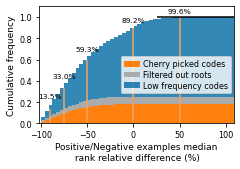

In [145]:
infrequent_codes = oh_diagnoses_df.columns[infrequent_codes_mask(oh_diagnoses_df)]
infrequent_codes = infrequent_codes.intersection(code_subset)
filtered_roots = oh_diagnoses_df.columns[sagi_filtered_out_roots_mask(oh_diagnoses_df)]
filtered_roots = filtered_roots.intersection(code_subset).difference(infrequent_codes)
sagi_codes = filter_Sagi_diagnoses(oh_diagnoses_df=oh_diagnoses_df)
plt.hist([rel_rank_ratios[rel_rank_ratios.index.difference(sagi_codes)]*100.0,
        rel_rank_ratios[filtered_roots]*100.0,
        rel_rank_ratios[infrequent_codes]*100.0],
        label=["Cherry picked codes","Filtered out roots","Low frequency codes"],
        bins=nbins,density=True,
        cumulative=True,stacked=True,
        #alpha=.7,
        color=["#FF800E","#ABABAB",'#006ba4cc']);
for thresh,vspace in zip([-.9,-.75,-.5,.0,.5],[.09,.09,.08,.055,.03]):
    perc = np.sum(rel_rank_ratios<thresh)/(~np.isnan(rel_rank_ratios)).sum()
    plt.vlines(thresh*100,0,perc,colors="sandybrown")
    #plt.hlines()
    plt.text(thresh*100, perc+vspace, f'{perc:.1%}',
             ha='center',
             va='bottom',
             multialignment='center',
             fontsize=7.5)
plt.hlines(1.0,25,110,colors='black')
plt.xlabel('Positive/Negative examples median\n rank relative difference (%)')
plt.ylabel('Cumulative frequency')
plt.ylim(0,1.1)
plt.xlim(-102,108)
plt.legend(frameon=True,
           #loc='center right',
           loc=(.42,.26),
           markerscale=.5)
plt.savefig(plots_dir/"posneg_examples_ranks_ratio_uF1.pdf",
            bbox_inches = "tight")

In [41]:
print("Max filtered out rank ratios: " + str((rel_rank_ratios[filtered_roots]).max()))
print("Max cherry picked rank ratios: " + str((rel_rank_ratios[rel_rank_ratios.index.difference(sagi_codes)]).max()))

Max filtered out rank ratios: -0.09422852323494135
Max cherry picked rank ratios: -0.048442562963633105


In [59]:
# Compute fraction of codes >=100 occurrences with psitive ranks more than halved
((rel_rank_ratios[filtered_roots]<=-.5).sum() + (rel_rank_ratios[rel_rank_ratios.index.difference(sagi_codes)]<=-.5).sum())/float(len(filtered_roots)+len(rel_rank_ratios.index.difference(sagi_codes)))

0.8365440747227088

### Fig. S6  Ranks vs code frequency distribution

In [172]:
# lowess with local linear regression and CI
# code from: https://james-brennan.github.io/posts/lowess_conf/
def lowess(x, y, f=1./3.):
    """
    Basic LOWESS smoother with uncertainty. 
    Note:
        - Not robust (so no iteration) and
             only normally distributed errors. 
        - No higher order polynomials d=1 
            so linear smoother.
    """
    # get some paras
    xwidth = f*(x.max()-x.min()) # effective width after reduction factor
    N = len(x) # number of obs
    # Don't assume the data is sorted
    order = np.argsort(x)
    # storage
    y_sm = np.zeros_like(y)
    y_stderr = np.zeros_like(y)
    # define the weigthing function -- clipping too!
    tricube = lambda d : np.clip((1- np.abs(d)**3)**3, 0, 1)
    # run the regression for each observation i
    for i in range(N):
        dist = np.abs((x[order][i]-x[order]))/xwidth
        w = tricube(dist)
        # form linear system with the weights
        A = np.stack([w, x[order]*w]).T
        b = w * y[order]
        ATA = A.T.dot(A)
        ATb = A.T.dot(b)
        # solve the syste
        sol = np.linalg.solve(ATA, ATb)
        # predict for the observation only
        yest = A[i].dot(sol)# equiv of A.dot(yest) just for k
        place = order[i]
        y_sm[place]=yest 
        sigma2 = (np.sum((A.dot(sol) -y [order])**2)/N )
        # Calculate the standard error
        y_stderr[place] = np.sqrt(sigma2 * 
                                A[i].dot(np.linalg.inv(ATA)
                                                    ).dot(A[i]))
    return y_sm, y_stderr

In [ ]:
# Correlation between positive examples ranks and code frequency
import scipy
code_subset = icd9_allcodes
total_ranks = False
predictions = pd.read_csv("/home/quentin/Projects/completion_pmsi/models/mimic-omop/sequentialNN_3/overall_NDCG/drugSexAge_AllCodes/best_models/1/"
                              +"predictions_test.csv.gz").set_index('visit_occurrence_id')
for pred,label in zip([predictions],['Model']):
    if total_ranks:
        pred_ranks = compute_predictions_ranks(pred)
    else:
        pred_ranks = compute_predictions_ranks(pred.loc[:,code_subset])
    pos_examples_median = np.nanmedian(np.where(test_oh_diagnoses_df.loc[:,code_subset].to_numpy()==1,pred_ranks.loc[:,code_subset].to_numpy(),np.nan), axis=0)
    neg_examples_median = np.nanmedian(np.where(test_oh_diagnoses_df.loc[:,code_subset].to_numpy()!=1,pred_ranks.loc[:,code_subset].to_numpy(),np.nan), axis=0)
    for subset,subset_name,col in zip([pos_examples_median,neg_examples_median],
                                      ['Positive examples','Negative examples'],
                                      ["tab:orange","tab:blue"]):
        x = test_oh_diagnoses_df.loc[:,code_subset].sum(axis=0)/float(test_oh_diagnoses_df.shape[0])
        y = subset
        mask = ~np.isnan(y) & test_oh_diagnoses_df.loc[:,code_subset].any(axis=0)
        x = x[mask]
        y = y[mask]
        y_sm, y_std = lowess(np.log10(x), y, f=1./3.)
        # plt.scatter(x,
        #             y,
        #             label='rho='+str(scipy.stats.spearmanr(x,y,nan_policy='omit').correlation)[0:6]
        #            )
        order = np.argsort(x)
        #x = np.argsort(np.argsort(-x)) #rank transform
        plt.plot(x[order], y_sm[order], label=subset_name,color=col)
        plt.fill_between(x[order], y_sm[order] - y_std[order],
                    y_sm[order] + y_std[order], alpha=0.3,color=col)
        plt.scatter(x, y, s=.6,marker=".",
                    color=col,
                    #alpha=.4,
                    )
#plt.plot([1,pred_ranks.shape[1]],[1,pred_ranks.shape[1]],label="Dummy",color="green")
plt.plot(x[order],np.argsort(np.argsort(-x[order])),label="Dummy",color="tab:green")
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Code Frequency')
plt.ylabel('Code median rank')
plt.legend(frameon=False)
plt.ylim(1,pred_ranks.shape[1])
#plt.ylim(1,600)
#plt.xlim(1,pred_ranks.shape[1])
plt.savefig(plots_dir/"posneg_examples_ranks_at_frequency.pdf")

### Fig. 2a Entropy reduction distribution

In [134]:
# Compute mutual information between predicted score and output, compute entropy reduction
from sklearn.feature_selection import mutual_info_classif
from hot_encoding import _entropy as entropy
from project_miscellaneous import filter_Sagi_diagnoses, infrequent_codes_mask, sagi_filtered_out_roots_mask
oh_diagnoses_df = pd.read_parquet(datadir/"oh_diagnoses_rollup.parquet").set_index('visit_occurrence_id')
code_subset = icd9_allcodes
entropy_df = pd.DataFrame(index=code_subset)
for crossval_suff in ['','_1','_2']:
    test_visits = pd.read_csv(datadir/("test_visits_id"+crossval_suff+".csv.gz")).squeeze()
    test_oh_diagnoses_df = oh_diagnoses_df.loc[test_visits,:]
    predictions = pd.read_csv("/home/quentin/Projects/completion_pmsi/models/mimic-omop/sequentialNN_3/overall_micro_F1/drugSexAge_AllCodes"+crossval_suff+"/best_models/1/"
                                +"predictions_test.csv.gz").set_index('visit_occurrence_id')

    mi = []
    for col in code_subset:
        mi.append(mutual_info_classif(X=predictions.loc[:,col].to_numpy().reshape((-1,1)),
                                      y=test_oh_diagnoses_df.loc[:,col],
                                      discrete_features=False,
                                      copy=True)[0])
        # Set to NaN for each column with no or all positive example in the test set
    s0_col = (test_oh_diagnoses_df.all() | ~test_oh_diagnoses_df.any()).to_numpy()
    entropy_df['mi'+crossval_suff] = mi
    entropy_df.loc[s0_col,'mi'+crossval_suff] = np.nan
entropy_df.rename(columns={'mi':'mi_0'})
entropy_df['mean_mi'] = entropy_df.aggregate(np.nanmean,axis=1)
s = []
for col in code_subset:
    s.append(entropy(oh_diagnoses_df.loc[:,col].sum()/float(oh_diagnoses_df.shape[0]),logbase=np.exp(1)))
entropy_df['entropy'] = s
infrequent_codes = oh_diagnoses_df.columns[infrequent_codes_mask(oh_diagnoses_df)]
infrequent_codes = infrequent_codes.intersection(code_subset)
filtered_roots = oh_diagnoses_df.columns[sagi_filtered_out_roots_mask(oh_diagnoses_df)]
filtered_roots = filtered_roots.intersection(code_subset).difference(infrequent_codes)
sagi_codes = filter_Sagi_diagnoses(oh_diagnoses_df=oh_diagnoses_df)
del oh_diagnoses_df

In [135]:
# Number of codes with estimate >1
(entropy_df.mean_mi/entropy_df.entropy > 1.0).sum()


38

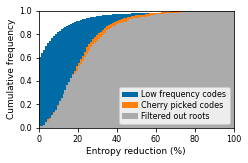

In [138]:
histbins = np.linspace(0,100,100)
entropy_df['entropy_reduction'] = entropy_df.mean_mi/entropy_df.entropy
entropy_df.loc[entropy_df.entropy_reduction >
               1.0, 'entropy_reduction'] = 1.0
lf_hist = plt.hist(entropy_df.entropy_reduction[infrequent_codes]*100, bins=histbins,
         density=True, cumulative=True,
         label='Low frequency codes',
         color="#006BA4",
         #alpha=.5
         )
# plot the remaining codes (neither filtered by frequence nor prior knowledge)
plt.hist(entropy_df.loc[entropy_df.index.difference(sagi_codes),:].entropy_reduction*100, bins=histbins, density=True,
         cumulative=True, label='Cherry picked codes',
         color="#FF800E",
         #alpha=.5,
         )
plt.hist(entropy_df.entropy_reduction[filtered_roots]*100, bins=histbins,
         density=True, cumulative=True,
         label='Filtered out roots',
         color="#ABABAB",
         #alpha=.5
         )

plt.legend(frameon=True, loc='lower right')
plt.xlim(0, 100)
plt.ylim(0, 1)
plt.xlabel('Entropy reduction (%)')
plt.ylabel('Cumulative frequency')
#plt.title("All codes entropy reduction uF1")
plt.savefig(plots_dir/"entropy_reduction_uF1.pdf")

In [32]:
# Fraction of low frequency codes with more than 10% entropy reduction
float((entropy_df.entropy_reduction[infrequent_codes]>.10).sum())/len(infrequent_codes)

0.3178068898592916

In [38]:
entropy_df.query('entropy_reduction>.90')

,mi,mi_1,mi_2,mean_mi,entropy,entropy_reduction
concept_code,,,,,,
091,NaN,NaN,2.401017e-03,0.002401,0.000719,1.000000
200.3,NaN,2.114348e-03,NaN,0.002114,0.001933,1.000000
249.11,NaN,NaN,5.101512e-04,0.000510,0.000554,0.921244
250.33,2.102530e-03,NaN,NaN,0.002103,0.001494,1.000000
272.6,NaN,1.464833e-03,NaN,0.001465,0.001192,1.000000
275.5,NaN,1.818862e-03,NaN,0.001819,0.001037,1.000000
279.51,1.221245e-15,NaN,3.237684e-03,0.001619,0.001642,0.986064
343.1,1.051751e-04,NaN,3.454350e-03,0.001780,0.000719,1.000000
365.63,NaN,NaN,2.399159e-03,0.002399,0.001192,1.000000


In [25]:
from scipy import stats
stats.mannwhitneyu(x=entropy_df.entropy_reduction[filtered_roots].dropna(),
                    y=entropy_df.loc[entropy_df.index.difference(sagi_codes),:].entropy_reduction.dropna())

MannwhitneyuResult(statistic=308625.0, pvalue=0.15453434178221834)

### Fig. S2 Entropy reduction by code frequency

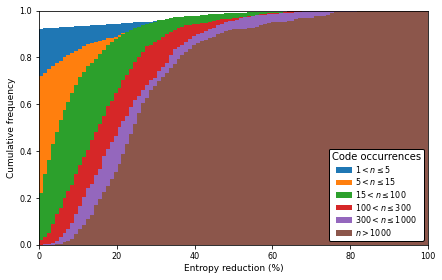

In [171]:
oh_diagnoses_df = pd.read_parquet(datadir/"oh_diagnoses_rollup.parquet").set_index('visit_occurrence_id')
code_occurrences = oh_diagnoses_df.sum(axis=0)
few_shot_codes = oh_diagnoses_df.columns[(code_occurrences>2) & (code_occurrences<=5)]
rare_codes = oh_diagnoses_df.columns[(code_occurrences>5) & (code_occurrences<=15)]
infrequent_codes = oh_diagnoses_df.columns[(code_occurrences>15) & (code_occurrences<=100)]
medium_freq_codes = oh_diagnoses_df.columns[(code_occurrences>100) & (code_occurrences<=300)]
frequent_codes = oh_diagnoses_df.columns[(code_occurrences>300) & (code_occurrences<=1000)]
highly_frequent_codes = oh_diagnoses_df.columns[(code_occurrences>1000)]

histbins = np.linspace(0,100,100)
entropy_df['entropy_reduction'] = entropy_df.mean_mi/entropy_df.entropy
entropy_df.loc[entropy_df.entropy_reduction >
               1.0, 'entropy_reduction'] = 1.0
plt.hist(entropy_df.entropy_reduction[few_shot_codes]*100, bins=histbins,
         density=True, cumulative=True, label=r'$1 < n \leq 5$', alpha=1.)
plt.hist(entropy_df.entropy_reduction[rare_codes]*100, bins=histbins,
         density=True, cumulative=True, label=r'$5 < n \leq 15$', alpha=1.)
plt.hist(entropy_df.entropy_reduction[infrequent_codes]*100, bins=histbins,
         density=True, cumulative=True, label=r'$15 < n \leq 100$', alpha=1.)
plt.hist(entropy_df.entropy_reduction[medium_freq_codes]*100, bins=histbins,
         density=True, cumulative=True, label=r'$100 < n \leq 300$', alpha=1.)
plt.hist(entropy_df.entropy_reduction[frequent_codes]*100, bins=histbins,
         density=True, cumulative=True, label=r'$300 < n \leq 1000$', alpha=1.)
plt.hist(entropy_df.entropy_reduction[highly_frequent_codes]*100, bins=histbins,
         density=True, cumulative=True, label=r'$n > 1000$', alpha=1, linewidth=1.5)
# plot the remaining codes (neither filtered by frequence nor prior knowledge)
#plt.hist(entropy_df.loc[entropy_df.index.difference(sagi_codes),:].entropy_reduction*100, bins=histbins, density=True,
#         cumulative=True, label='Remaining codes', alpha=.5)
plt.legend(edgecolor="k",framealpha=1.0, loc='lower right',title="Code occurrences")
plt.xlim(0, 100)
plt.ylim(0, 1)
plt.xlabel('Entropy reduction (%)')
plt.ylabel('Cumulative frequency')
#plt.title("All codes entropy reduction uF1")
plt.gcf().set_size_inches(dual_col_fig_size)
plt.savefig(plots_dir/"entropy_reduction_infrequent_codes_uF1.pdf")
del oh_diagnoses_df

In [27]:
print(len(few_shot_codes))
print(len(rare_codes))
print(len(infrequent_codes))
print(len(medium_freq_codes))
print(len(frequent_codes))
print(len(highly_frequent_codes))

1350
1598
2061
783
510
410


# Table S9 Performance per stay type (medical, surgical, newborn)
Check whether the models performs about equally on 3 patients subsets: newborns, surgical patients and medical patients

In [3]:
visit_details = pd.read_csv(
    datadir/"../visit_detail.csv.gz",
    usecols=["visit_occurrence_id","visit_detail_concept_id"])

In [54]:
def categorize_visit(x: pd.DataFrame):
    """
    Translate visit detail concept codes to string.

    Patients with at least one newborn tag are considered newborns, among the
    remaining patients the ones with at least one surgical tag are considered
    surgical, the remaining ones are considered medical patients.
    """
    x=set(x)
    if 4237225 in x:
        return "newborn"
    elif 4149152 in x:
        return "surgical"
    elif 45763735 in x:
        return "medical"
    else:
        return None


In [60]:
visit_categories = visit_details.groupby("visit_occurrence_id").agg(categorize_visit)
visit_categories.value_counts()

visit_detail_concept_id
medical                    26883
surgical                   23947
newborn                     8096
dtype: int64

In [87]:
from project_miscellaneous import filter_Sagi_diagnoses
import sklearn.metrics as skmet
oh_diagnoses_df = pd.read_parquet(
    datadir/"oh_diagnoses_rollup.parquet").set_index('visit_occurrence_id')

icd9_concepts = pd.read_csv(datadir / "icd9_concepts.csv.gz")
icd9_allcodes = icd9_concepts[icd9_concepts.concept_code.isin(oh_diagnoses_df.columns)].concept_code
icd9_chapters = icd9_concepts[icd9_concepts.concept_code.isin(oh_diagnoses_df.columns)].query('concept_class_id=="Chapter"').concept_code
icd9_subchapters = (icd9_concepts[icd9_concepts.concept_code.isin(oh_diagnoses_df.columns)].query('concept_class_id=="SubChapter"')
                    .concept_code)
icd9_3dig = (icd9_concepts[icd9_concepts.concept_code.isin(oh_diagnoses_df.columns)].query('concept_class_id.str.startswith("3-dig",'
                                'na=False)').concept_code)
icd9_4dig = (icd9_concepts[icd9_concepts.concept_code.isin(oh_diagnoses_df.columns)].query('concept_class_id.str.startswith("4-dig",'
                                'na=False)').concept_code)
icd9_5dig = (icd9_concepts[icd9_concepts.concept_code.isin(oh_diagnoses_df.columns)].query('concept_class_id.str.startswith("5-dig",'
                                'na=False)').concept_code)
icd9_billing = (
    icd9_concepts[icd9_concepts.concept_code.isin(oh_diagnoses_df.columns)].query('concept_class_id.str.endswith("-dig billing code",'
                        'na=False)').concept_code)


base_dir = "/home/quentin/Projects/completion_pmsi/models/mimic-omop/sequentialNN_3/"

metrics_func_dict = {
    'micro_AUROC':lambda y_true,y_score: skmet.roc_auc_score(y_true=y_true, y_score=y_score, average='micro'),
    'macro_AUROC':lambda y_true,y_score: macro_averaged_AUROC(*filter_no_positive_label(y_true, y_score),pos_label=1),
    
    'micro_AUPRC': lambda y_true,y_score: micro_averaged_auc_PR(y_true=y_true, probas_pred=y_score, pos_label=1),
    'macro_AUPRC': lambda y_true,y_score: macro_averaged_auc_PR(*filter_no_positive_label(y_true, y_score), pos_label=1),
    
    'NDCG': lambda y_true,y_score: skmet.ndcg_score(y_true=y_true,y_score=y_score, k=None),

    'NDCG@15': lambda y_true,y_score: skmet.ndcg_score(y_true=y_true,y_score=y_score, k=15),
}
for p in [25,50,75,100]:
    metrics_func_dict['RE@'+str(p)] = lambda y_true,y_score,q=p: np.nanmean(kumet.rank_errors_at_percentile(y_true=y_true, y_pred=y_score, q=q, no_true_label_value=None).numpy())

stays_filters_dict = {
    'Newborns': lambda x: x.index.isin(visit_categories.query("visit_detail_concept_id=='newborn'").index),
    'Surgical': lambda x: x.index.isin(visit_categories.query("visit_detail_concept_id=='surgical'").index),
    'Medical': lambda x: x.index.isin(visit_categories.query("visit_detail_concept_id=='medical'").index)
}
results_df = pd.DataFrame()

def compute_metrics(truth_df,predictions_df, metrics_list):

    predictions_df.sort_index(ascending=True,inplace=True)
    truth_df.sort_index(ascending=True,inplace=True)

    metrics_df = pd.DataFrame()

    for code_subset, code_subset_name in zip([icd9_allcodes, icd9_chapters, icd9_subchapters, icd9_3dig, icd9_billing],
                                            ['All', 'Chapter', 'Subchapter', '3 digits', 'Billing']):
        for filter_name,filter_func in stays_filters_dict.items():
            code_subset_dict = {"Hierarchy level":[code_subset_name], "Filter":[filter_name]}
            filtered_visits = filter_func(truth_df)
            for metric in metrics_list:
                code_subset_dict[metric] = [metrics_func_dict[metric](truth_df.loc[filtered_visits,code_subset].to_numpy(),
                                                                    predictions_df.loc[filtered_visits,code_subset].to_numpy())]
            metrics_df = pd.concat([metrics_df, pd.DataFrame(code_subset_dict)])
    return metrics_df

for crossval_suffix,crossval_id in zip(['', '_1', '_2'],[0,1,2]):
    visit_ids = pd.read_csv(datadir/('test_visits_id'+crossval_suffix+'.csv.gz')).squeeze()
    test_oh_diagnoses_df = oh_diagnoses_df.loc[visit_ids,:]
    metrics_df = pd.DataFrame()
    # Compute RE,NDCG and NDCG@15 on NDCG experiment
    test_predictions = pd.read_csv(
        base_dir+"overall_NDCG/drugSexAge_AllCodes"+crossval_suffix
        +"/best_models/1/predictions_test.csv.gz").set_index('visit_occurrence_id')
    tmp = compute_metrics(test_oh_diagnoses_df,test_predictions,
                ['NDCG','NDCG@15','RE@25','RE@50','RE@75','RE@100'])
    metrics_df = pd.concat([metrics_df, tmp])
    # Compute micro AUROC
    test_predictions = pd.read_csv(
        base_dir+"overall_micro_AUROC/drugSexAge_AllCodes"+crossval_suffix
        +"/best_models/1/predictions_test.csv.gz").set_index('visit_occurrence_id')
    tmp = compute_metrics(test_oh_diagnoses_df,test_predictions,
            ['micro_AUROC'])
    metrics_df = pd.merge(metrics_df, tmp,on=["Hierarchy level","Filter"])
    # Compute macro AUROC
    test_predictions = pd.read_csv(
        base_dir+"overall_macro_AUROC/drugSexAge_AllCodes"+crossval_suffix
        +"/best_models/1/predictions_test.csv.gz").set_index('visit_occurrence_id')
    tmp = compute_metrics(test_oh_diagnoses_df,test_predictions,
                ['macro_AUROC'])
    metrics_df = pd.merge(metrics_df, tmp,on=["Hierarchy level","Filter"])
    # Compute micro AUPRC and LRAP
    test_predictions = pd.read_csv(
        base_dir+"overall_micro_aucPR/drugSexAge_AllCodes"+crossval_suffix
        +"/best_models/1/predictions_test.csv.gz").set_index('visit_occurrence_id')
    tmp = compute_metrics(test_oh_diagnoses_df,test_predictions,
                ['micro_AUPRC'])
    metrics_df = pd.merge(metrics_df, tmp,on=["Hierarchy level","Filter"])
    # Compute macro AUPRC
    test_predictions = pd.read_csv(
        base_dir+"overall_macro_aucPR/drugSexAge_AllCodes"+crossval_suffix
        +"/best_models/1/predictions_test.csv.gz").set_index('visit_occurrence_id')
    tmp = compute_metrics(test_oh_diagnoses_df,test_predictions,
                ['macro_AUPRC'])
    metrics_df = pd.merge(metrics_df, tmp,on=["Hierarchy level","Filter"])
    
    metrics_df['crossval_id'] = crossval_id
    results_df = pd.concat([results_df,metrics_df])
results_df.to_csv(tables_dir/'performance_metrics_per_stay_type.csv',index=False)

In [6]:
results_df = pd.read_csv(tables_dir/'performance_metrics_per_stay_type.csv',index_col=['Filter','Hierarchy level'])
ranking_metrics = ['NDCG','NDCG@15','RE@25','RE@50','RE@75','RE@100']
soft_classif_metrics = ["micro_AUROC", "macro_AUROC", "micro_AUPRC","macro_AUPRC"]
non_RE_cols = results_df.columns[~results_df.columns.str.startswith('RE@')]
results_df.loc[:,non_RE_cols]*=100
results_df = results_df.reset_index(drop=False).melt(id_vars=['Filter','Hierarchy level','crossval_id'],var_name='metric',value_name='value')
results_df = results_df.drop(columns='crossval_id').groupby(by=["Filter",'Hierarchy level','metric']).aggregate(['mean','sem'])
results_df = results_df.droplevel(level=0,axis=1)
results_df['value'] = results_df.apply(lambda x: str(x['mean'])[0:5] + ' $\pm$ ' + str(x['sem'])[0:4],axis=1)
results_df = results_df.drop(columns=['mean','sem']).reset_index()
results_df = results_df.rename(columns={"metric":"Metric"})
results_df = results_df.pivot(index=["Filter","Hierarchy level"],columns="Metric", values='value')
results_df = results_df.reindex(["Chapter","Subchapter","3 digits","Billing","All"], level="Hierarchy level")

results_df.style.to_latex(buf=tables_dir/"perf_per_stay_type.tex",
                environment='void',hrules=True,clines="skip-last;index",column_format='llrrrrrrrrrr')
results_df.loc[:,ranking_metrics].style.to_latex(buf=tables_dir/"ranking_perf_per_stay_type.tex",
                environment='void',hrules=True,clines="skip-last;index",column_format='llrrrrrr')

results_classif_df = results_df.loc[:,soft_classif_metrics]
results_classif_df.columns = results_classif_df.columns.str.replace(pat='micro_',repl="$\mu$",regex=False)
results_classif_df.columns = results_classif_df.columns.str.replace(pat='macro_',repl="macro ",regex=False)
results_classif_df.style.to_latex(buf=tables_dir/"softclassif_perf_per_stay_type.tex",
                environment='void',hrules=True,clines="skip-last;index",column_format='llrrrr')

In [5]:
results_df

Metric                                NDCG           NDCG@15  \
Filter   Hierarchy level                                       
Medical  Chapter          92.78 $\pm$ 0.11  92.13 $\pm$ 0.13   
         Subchapter       84.41 $\pm$ 0.17  72.63 $\pm$ 0.16   
         3 digits         75.80 $\pm$ 0.17  57.94 $\pm$ 0.14   
         Billing          66.40 $\pm$ 0.13  46.54 $\pm$ 0.10   
         All              83.36 $\pm$ 0.14  76.24 $\pm$ 0.29   
Newborns Chapter          97.10 $\pm$ 0.35  96.59 $\pm$ 0.45   
         Subchapter       94.70 $\pm$ 0.38  93.55 $\pm$ 0.44   
         3 digits         88.48 $\pm$ 0.59  84.74 $\pm$ 0.67   
         Billing          41.05 $\pm$ 0.31  34.62 $\pm$ 0.38   
         All              91.91 $\pm$ 0.43  84.36 $\pm$ 0.70   
Surgical Chapter          90.28 $\pm$ 0.01  89.65 $\pm$ 0.07   
         Subchapter       79.96 $\pm$ 0.06  68.50 $\pm$ 0.02   
         3 digits         70.91 $\pm$ 0.20  53.03 $\pm$ 0.14   
         Billing          62.44 $\pm$ 0.30  44.31 $\pm$ 0.25   
         All              79.87 $\pm$ 0.07  69.78 $\pm$ 0.14   

Metric                              RE@100             RE@25  \
Filter   Hierarchy level                                       
Medical  Chapter          4.281 $\pm$ 0.01  0.367 $\pm$ 0.00   
         Subchapter       29.68 $\pm$ 0.30  1.474 $\pm$ 0.03   
         3 digits         171.8 $\pm$ 1.67  4.631 $\pm$ 0.09   
         Billing          848.1 $\pm$ 9.76  12.19 $\pm$ 0.24   
         All              1827. $\pm$ 20.0  6.689 $\pm$ 0.21   
Newborns Chapter          1.157 $\pm$ 0.06  0.105 $\pm$ 0.02   
         Subchapter       3.350 $\pm$ 0.18  0.354 $\pm$ 0.06   
         3 digits         23.68 $\pm$ 0.33  2.019 $\pm$ 0.58   
         Billing          280.6 $\pm$ 13.5  25.20 $\pm$ 6.54   
         All              383.0 $\pm$ 23.7  4.354 $\pm$ 0.96   
Surgical Chapter          4.677 $\pm$ 0.03  0.516 $\pm$ 0.00   
         Subchapter       30.95 $\pm$ 0.01  2.438 $\pm$ 0.04   
         3 digits         169.3 $\pm$ 1.39  7.640 $\pm$ 0.20   
         Billing          893.6 $\pm$ 18.2  26.08 $\pm$ 1.07   
         All              1965. $\pm$ 44.1  11.08 $\pm$ 0.80   

Metric                               RE@50             RE@75  \
Filter   Hierarchy level                                       
Medical  Chapter          0.973 $\pm$ 0.00  2.137 $\pm$ 0.02   
         Subchapter       4.045 $\pm$ 0.04  10.43 $\pm$ 0.09   
         3 digits         14.24 $\pm$ 0.08  40.78 $\pm$ 0.24   
         Billing          39.96 $\pm$ 0.25  131.6 $\pm$ 1.88   
         All              33.94 $\pm$ 0.44  143.1 $\pm$ 0.59   
Newborns Chapter          0.217 $\pm$ 0.04  0.635 $\pm$ 0.04   
         Subchapter       0.645 $\pm$ 0.09  1.450 $\pm$ 0.09   
         3 digits         3.805 $\pm$ 0.88  7.805 $\pm$ 1.14   
         Billing          46.08 $\pm$ 11.9  89.73 $\pm$ 17.8   
         All              12.46 $\pm$ 2.50  37.46 $\pm$ 6.99   
Surgical Chapter          1.189 $\pm$ 0.01  2.496 $\pm$ 0.02   
         Subchapter       5.533 $\pm$ 0.12  12.29 $\pm$ 0.11   
         3 digits         19.71 $\pm$ 0.23  49.83 $\pm$ 0.26   
         Billing          66.98 $\pm$ 2.00  194.0 $\pm$ 3.44   
         All              49.25 $\pm$ 1.13  186.6 $\pm$ 3.95   

Metric                         macro_AUPRC       macro_AUROC  \
Filter   Hierarchy level                                       
Medical  Chapter          64.86 $\pm$ 0.23  78.65 $\pm$ 0.27   
         Subchapter       27.62 $\pm$ 0.32  79.72 $\pm$ 0.57   
         3 digits         14.39 $\pm$ 0.20  79.97 $\pm$ 0.15   
         Billing          8.992 $\pm$ 0.13  80.75 $\pm$ 0.16   
         All              11.29 $\pm$ 0.21  80.50 $\pm$ 0.13   
Newborns Chapter          22.32 $\pm$ 0.75  72.17 $\pm$ 1.59   
         Subchapter       18.94 $\pm$ 2.40  74.60 $\pm$ 1.17   
         3 digits         14.52 $\pm$ 0.36  72.98 $\pm$ 0.32   
         Billing          9.891 $\pm$ 0.14  72.63 $\pm$ 0.71   
         All              12.

# Table S5 Model Calibration

In [9]:
#from estimating_eces.explicalib.calibration.evaluation.metrics import confidence as confidence_ece
import calibration
from importlib import reload
reload(calibration)

<module 'calibration' from '/home/quentin/Projects/completion_pmsi/code/libs/calibration.py'>

In [10]:
import tensorflow_probability as tfp
import sklearn.metrics as skmet
def logit(p):
    return np.log(p) - np.log(1 - p)


oh_diagnoses_df = pd.read_parquet(
    datadir/"oh_diagnoses_rollup.parquet").set_index('visit_occurrence_id')

icd9_concepts = pd.read_csv(datadir / "icd9_concepts.csv.gz")
icd9_allcodes = icd9_concepts[icd9_concepts.concept_code.isin(oh_diagnoses_df.columns)].concept_code
icd9_chapters = icd9_concepts[icd9_concepts.concept_code.isin(oh_diagnoses_df.columns)].query('concept_class_id=="Chapter"').concept_code
icd9_subchapters = (icd9_concepts[icd9_concepts.concept_code.isin(oh_diagnoses_df.columns)].query('concept_class_id=="SubChapter"')
                    .concept_code)
icd9_3dig = (icd9_concepts[icd9_concepts.concept_code.isin(oh_diagnoses_df.columns)].query('concept_class_id.str.startswith("3-dig",'
                                'na=False)').concept_code)
icd9_4dig = (icd9_concepts[icd9_concepts.concept_code.isin(oh_diagnoses_df.columns)].query('concept_class_id.str.startswith("4-dig",'
                                'na=False)').concept_code)
icd9_5dig = (icd9_concepts[icd9_concepts.concept_code.isin(oh_diagnoses_df.columns)].query('concept_class_id.str.startswith("5-dig",'
                                'na=False)').concept_code)
icd9_billing = (
    icd9_concepts[icd9_concepts.concept_code.isin(oh_diagnoses_df.columns)].query('concept_class_id.str.endswith("-dig billing code",'
                        'na=False)').concept_code)

base_dir = str(get_modelsdir())+"/mimic-omop/sequentialNN_3/"




In [16]:
results_df = pd.DataFrame()
for crossval_suffix,crossval_id in zip(['', '_1', '_2'],[0,1,2]):
    visit_ids = pd.read_csv(datadir/('test_visits_id'+crossval_suffix+'.csv.gz')).squeeze()
    test_oh_diagnoses_df = oh_diagnoses_df.loc[visit_ids,:]
    metrics_df = pd.DataFrame()
    # Compute RE,NDCG and NDCG@15 on NDCG experiment
    test_predictions = pd.read_csv(
        base_dir+"overall_NDCG/drugSexAge_AllCodes"+crossval_suffix
        +"/best_models/1/predictions_test.csv.gz").set_index('visit_occurrence_id')
    
    # Convert the binary multilabel predictions to a fake 2 mod multiclass
    flatten_pred = test_predictions.to_numpy().flatten()
    pred_probas = np.zeros((flatten_pred.shape[0],2))
    pred_probas[:,0] = 1.0 - flatten_pred
    pred_probas[:,1] = flatten_pred

    ece, mce = calibration.confidence_ece_a(
        probas_pred=pred_probas,
        Y=test_oh_diagnoses_df.to_numpy().flatten(),
        n_bins=500,  # "sqrt",
        backend="accuracies_confidences",
        summarizing_function=("average","max"))
    brier = skmet.brier_score_loss(
        y_true=test_oh_diagnoses_df.to_numpy().flatten(),
        y_prob=pred_probas[:,1],
        pos_label=1)
    tmp = pd.DataFrame({"metric":["NDCG"],
                    "crossval_id":[crossval_id],
                    "ECE":[ece],
                    "MCE":[mce],
                    "Brier score":[brier]})
    print(tmp)
    results_df = pd.concat([results_df,tmp])


  metric  crossval_id       ECE       MCE  Brier score
0   NDCG            0  0.000686  0.029386     0.002816
  metric  crossval_id       ECE       MCE  Brier score
0   NDCG            1  0.000486  0.018163     0.002869
  metric  crossval_id       ECE       MCE  Brier score
0   NDCG            2  0.000498  0.021384     0.002863


In [17]:
# Compute ECE on AUCPR models
for crossval_suffix,crossval_id in zip(['', '_1', '_2'],[0,1,2]):
    visit_ids = pd.read_csv(datadir/('test_visits_id'+crossval_suffix+'.csv.gz')).squeeze()
    test_oh_diagnoses_df = oh_diagnoses_df.loc[visit_ids,:]
    metrics_df = pd.DataFrame()
    # Compute RE,NDCG and NDCG@15 on NDCG experiment
    test_predictions = pd.read_csv(
        base_dir+"overall_micro_aucPR/drugSexAge_AllCodes"+crossval_suffix
        +"/best_models/1/predictions_test.csv.gz").set_index('visit_occurrence_id')
    
    # Convert the binary multilabel predictions to a fake 2 mod multiclass
    flatten_pred = test_predictions.to_numpy().flatten()
    pred_probas = np.zeros((flatten_pred.shape[0],2))
    pred_probas[:,0] = 1.0 - flatten_pred
    pred_probas[:,1] = flatten_pred    

    ece, mce = calibration.confidence_ece_a(
        probas_pred=pred_probas,
        Y=test_oh_diagnoses_df.to_numpy().flatten(),
        n_bins=500,  # "sqrt",
        backend="accuracies_confidences",
        summarizing_function=("average","max"))
    brier = skmet.brier_score_loss(
        y_true=test_oh_diagnoses_df.to_numpy().flatten(),
        y_prob=pred_probas[:,1],
        pos_label=1)
    tmp = pd.DataFrame({"metric":["AUPRC"],
                    "crossval_id":[crossval_id],
                    "ECE":[ece],
                    "MCE":[mce],
                    "Brier score":[brier]})
    results_df = pd.concat([results_df,tmp])

In [18]:
results_df.to_csv(tables_dir/"calibration.csv",index=False)

In [20]:
results_df = pd.read_csv(tables_dir/"calibration.csv",index_col=['metric','crossval_id'])
results_df.loc[:,:]*=100
results_df = results_df.reset_index(drop=False).melt(id_vars=['metric','crossval_id'],var_name='cal_metric',value_name='value')
results_df = results_df.drop(columns='crossval_id').groupby(by=["metric",'cal_metric']).aggregate(['mean','sem'])
results_df = results_df.droplevel(level=0,axis=1)
results_df['value'] = results_df.apply(lambda x: str(x['mean'])[0:5] + ' $\pm$ ' + str(x['sem'])[0:4] + "\%",axis=1)
results_df = results_df.drop(columns=['mean','sem']).reset_index()
results_df = results_df.rename(columns={"metric":"Optimized Metric","cal_metric":"Calibration Metric"})
results_df = results_df.pivot(index=["Optimized Metric"],columns="Calibration Metric", values='value')
print(results_df)
results_df.style.to_latex(buf=tables_dir/"calibration_perf.tex",
                environment='void',hrules=True,clines="skip-last;index",column_format='llccc')

Calibration Metric         Brier score                 ECE                 MCE
Optimized Metric                                                              
AUPRC               0.282 $\pm$ 0.00\%  0.039 $\pm$ 0.00\%  1.171 $\pm$ 0.23\%
NDCG                0.284 $\pm$ 0.00\%  0.055 $\pm$ 0.00\%  2.297 $\pm$ 0.33\%


In [8]:
results_df

Calibration Metric,Brier score,ECE,MCE,Unnamed: 0
Optimized Metric,,,,
AUPRC,0.282 $\pm$ 0.00\%,0.039 $\pm$ 0.00\%,1.171 $\pm$ 0.23\%,0.0 $\pm$ 0.0\%
NDCG,0.284 $\pm$ 0.00\%,0.055 $\pm$ 0.00\%,2.297 $\pm$ 0.33\%,0.0 $\pm$ 0.0\%


# Table S10 Best models hyperparameters

In [39]:
models_dir = get_modelsdir() / "mimic-omop/sequentialNN_3/"
met_dirs = listdir_only(models_dir)
hyper_parms_df = pd.DataFrame()
for metric in met_dirs:
    exp_runs = listdir_only(models_dir/metric)
    #exp_dirs = [models_dir/metric/exp/'best_models' for exp in exp_dirs]
    for exp in exp_runs:
        # process model_str
        tmp = process_model_str(pd.DataFrame({'model_str':[exp],
                                'metric_value':[0.0]
            }))
        exp_dir = models_dir/metric/exp/'best_models'
        # print(exp_dir)
        # Read model json file 
        with open(exp_dir/"1/model_hyperparameters.json") as json_file:
            model_json = json_file.read()
            # convert to to dataframe
            model_json = pd.DataFrame({"metric":metric,
                                       "exp_name":exp.split("_")[1],
                                       "crossval_id":exp.split("_")[-1],
                                       **json.loads(model_json)},index=[0])
        hyper_parms_df = pd.concat([hyper_parms_df,
                                    model_json],
                                   axis=0)
hyper_parms_df = hyper_parms_df.reset_index(drop=True)
hyper_parms_df.loc[~hyper_parms_df.crossval_id.str.isnumeric(),"crossval_id"] = 0

In [40]:
hyper_parms_df

,metric,exp_name,crossval_id,dropout,batchnorm,num_layers,units,activation,tuner/epochs,tuner/initial_epoch,tuner/bracket,tuner/round,tuner/trial_id,outhier_lambda,out_L2,IR_cap,focal_g
0,overall_macro_AUROC,AllCodes,0,0.719302,True,3,3840,relu,50,17,4,3,0386,NaN,NaN,NaN,NaN
1,overall_macro_AUROC,AllCodes,1,0.784277,True,3,3840,relu,50,17,2,1,0465,NaN,NaN,NaN,NaN
2,overall_macro_AUROC,AllCodes,2,0.784277,True,3,3840,relu,50,17,3,2,0445,NaN,NaN,NaN,NaN
3,overall_macro_aucPR,AllCodes,0,0.649855,True,3,3840,relu,50,17,3,2,0192,NaN,NaN,NaN,NaN
4,overall_macro_aucPR,AllCodes,1,0.640512,True,3,4864,relu,50,17,3,2,0193,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,overall_macro_F1,AllCodes,1,0.642097,True,3,5376,relu,150,0,0,0,NaN,NaN,NaN,NaN,NaN
65,overall_macro_F1,AllCodes,2,0.517681,True,3,5376,relu,50,17,3,2,0190,NaN,NaN,NaN,NaN
66,overall_micro_aucPR,AllCodes,0,0.736253,False,2,4608,relu,150,50,2,2,0229,NaN,NaN,NaN,NaN
67,overall_micro_aucPR,AllCodes,1,0.669924,False,2,1536,relu,150,0,0,0,NaN,NaN,NaN,NaN,NaN


In [57]:
# Write to csv excluding some uninteresting columns
(hyper_parms_df.drop(columns=['activation','tuner/epochs',"tuner/initial_epoch","tuner/trial_id"])
 .sort_values(["metric","exp_name","crossval_id"])
 .to_csv(tables_dir/"best_hyperparms.csv",index=False))

In [65]:
# Make a latex table of the hyperpaameters of the best NDCG models
tmp = hyper_parms_df.query('metric=="overall_NDCG" & exp_name=="AllCodes"').loc[:,["crossval_id","batchnorm","num_layers","units","dropout"]]
# Rename columns for publication
tmp.columns = ["Cross-validation ID","Batch Normalization","Number of Layers","Number of Units","Dropout Rate"]
# Export to latex table
tmp.set_index("Cross-validation ID",drop=True).style.format(precision=2).to_latex(tables_dir/"AllCodes_best_NDCG_hyperparams.tex",environment='void',hrules=True,column_format='crrrr')